In [3]:
# Import packages

import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyart
import glob
import matplotlib.patheffects as path_effects
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap
from pyproj import Transformer
import radlib
import os
import h5py
import matplotlib.dates as mdates
from scipy.ndimage import gaussian_filter1d
from cartopy.feature import NaturalEarthFeature
import xmltodict, geopandas, geojson, xml #xml and json do not exist
from datetime import datetime, timedelta, timezone
import geopy.distance
from datetime import datetime, timedelta
import numpy.matlib as npm
import copy
from scipy.signal import convolve2d
from astropy.convolution import convolve
import scipy.ndimage as ndi
import re
from skimage.draw import polygon

from pprint import pprint
from pysteps import io, motion, rcparams
from pysteps.utils import conversion, transformation
from pysteps.visualization import plot_precip_field, quiver

import json

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

import polars as pl

import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

import geopandas as gpd
from shapely.geometry import Point

from mpl_toolkits.mplot3d import Axes3D

from shapely.geometry import Polygon


from geopandas import GeoDataFrame
import datetime

import matplotlib.patches as patches

import geojson as gs


os.environ["library_metranet_path"] = "/store_new/mch/msrad/idl/lib/radlib4/" # needed for pyradlib
os.environ["METRANETLIB_PATH"] = "/store_new/mch/msrad/idl/lib/radlib4/" # needed for pyart_mch




## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

Pysteps configuration file found at: /scratch/mch/fackerma/miniforge3/envs/testenv/lib/python3.12/site-packages/pysteps/pystepsrc



## Libraries & Definitions 

In [7]:
# Data Imports, processing, norming, etc.

# GPSConverter for coordinate transformation
class GPSConverter(object):
    '''
    GPS Converter class which is able to perform convertions between the 
    CH1903 and WGS84 system.
    '''
    # Convert CH y/x/h to WGS height
    def CHtoWGSheight(self, y, x, h):
        # Axiliary values (% Bern)
        y_aux = (y - 600000) / 1000000
        x_aux = (x - 200000) / 1000000
        h = (h + 49.55) - (12.60 * y_aux) - (22.64 * x_aux)
        return h

    # Convert CH y/x to WGS lat
    def CHtoWGSlat(self, y, x):
        # Axiliary values (% Bern)
        y_aux = (y - 600000) / 1000000
        x_aux = (x - 200000) / 1000000
        lat = (16.9023892 + (3.238272 * x_aux)) + \
                - (0.270978 * pow(y_aux, 2)) + \
                - (0.002528 * pow(x_aux, 2)) + \
                - (0.0447 * pow(y_aux, 2) * x_aux) + \
                - (0.0140 * pow(x_aux, 3))
        # Unit 10000" to 1" and convert seconds to degrees (dec)
        lat = (lat * 100) / 36
        return lat

    # Convert CH y/x to WGS long
    def CHtoWGSlng(self, y, x):
        # Axiliary values (% Bern)
        y_aux = (y - 600000) / 1000000
        x_aux = (x - 200000) / 1000000
        lng = (2.6779094 + (4.728982 * y_aux) + \
                + (0.791484 * y_aux * x_aux) + \
                + (0.1306 * y_aux * pow(x_aux, 2))) + \
                - (0.0436 * pow(y_aux, 3))
        # Unit 10000" to 1" and convert seconds to degrees (dec)
        lng = (lng * 100) / 36
        return lng

    # Convert decimal angle (° dec) to sexagesimal angle (dd.mmss,ss)
    def DecToSexAngle(self, dec):
        degree = int(math.floor(dec))
        minute = int(math.floor((dec - degree) * 60))
        second = (((dec - degree) * 60) - minute) * 60
        return degree + (float(minute) / 100) + (second / 10000)
		
    # Convert sexagesimal angle (dd.mmss,ss) to seconds
    def SexAngleToSeconds(self, dms):
        degree = 0 
        minute = 0 
        second = 0
        degree = math.floor(dms)
        minute = math.floor((dms - degree) * 100)
        second = (((dms - degree) * 100) - minute) * 100
        return second + (minute * 60) + (degree * 3600)

    # Convert sexagesimal angle (dd.mmss) to decimal angle (degrees)
    def SexToDecAngle(self, dms):
        degree = 0
        minute = 0
        second = 0
        degree = math.floor(dms)
        minute = math.floor((dms - degree) * 100)
        second = (((dms - degree) * 100) - minute) * 100
        return degree + (minute / 60) + (second / 3600)
    
    # Convert WGS lat/long (° dec) and height to CH h
    def WGStoCHh(self, lat, lng, h):
        lat = self.DecToSexAngle(lat)
        lng = self.DecToSexAngle(lng)
        lat = self.SexAngleToSeconds(lat)
        lng = self.SexAngleToSeconds(lng)
        # Axiliary values (% Bern)
        lat_aux = (lat - 169028.66) / 10000
        lng_aux = (lng - 26782.5) / 10000
        h = (h - 49.55) + (2.73 * lng_aux) + (6.94 * lat_aux)
        return h

    # Convert WGS lat/long (° dec) to CH x
    def WGStoCHx(self, lat, lng):
        lat = self.DecToSexAngle(lat)
        lng = self.DecToSexAngle(lng)
        lat = self.SexAngleToSeconds(lat)
        lng = self.SexAngleToSeconds(lng)
        # Axiliary values (% Bern)
        lat_aux = (lat - 169028.66) / 10000
        lng_aux = (lng - 26782.5) / 10000
        x = ((200147.07 + (308807.95 * lat_aux) + \
            + (3745.25 * pow(lng_aux, 2)) + \
            + (76.63 * pow(lat_aux,2))) + \
            - (194.56 * pow(lng_aux, 2) * lat_aux)) + \
            + (119.79 * pow(lat_aux, 3))
        return x

	# Convert WGS lat/long (° dec) to CH y
    def WGStoCHy(self, lat, lng):
        lat = self.DecToSexAngle(lat)
        lng = self.DecToSexAngle(lng)
        lat = self.SexAngleToSeconds(lat)
        lng = self.SexAngleToSeconds(lng)
        # Axiliary values (% Bern)
        lat_aux = (lat - 169028.66) / 10000
        lng_aux = (lng - 26782.5) / 10000
        y = (600072.37 + (211455.93 * lng_aux)) + \
            - (10938.51 * lng_aux * lat_aux) + \
            - (0.36 * lng_aux * pow(lat_aux, 2)) + \
            - (44.54 * pow(lng_aux, 3))
        return y

    def LV03toWGS84(self, east, north, height):
        '''
        Convert LV03 to WGS84 Return a array of double that contain lat, long,
        and height
        '''
        d = []
        d.append(self.CHtoWGSlat(east, north))
        d.append(self.CHtoWGSlng(east, north))
        d.append(self.CHtoWGSheight(east, north, height))
        return d
        
    def WGS84toLV03(self, latitude, longitude, ellHeight):
        '''
        Convert WGS84 to LV03 Return an array of double that contaign east,
        north, and height
        '''
        d = []
        d.append(self.WGStoCHy(latitude, longitude))
        d.append(self.WGStoCHx(latitude, longitude))
        d.append(self.WGStoCHh(latitude, longitude, ellHeight))
        return d

# Transform function for dealiased velocity
def transform_from_digital(mydata, nyquist):
    myfinaldata = (mydata * 1.0 - 128) * nyquist / 127
    myfinaldata[mydata == 0] = np.nan
    return myfinaldata

# Convert polar coordinates (range, azimuth) to geographic coordinates (lat/lon)
def radar_to_latlon(radar_lat, radar_lon, ranges, azimuths):
    R = 6371.0  # Earth radius in kilometers
    azimuths_rad = np.radians(azimuths)
    latitudes = np.zeros((len(azimuths), len(ranges)))
    longitudes = np.zeros((len(azimuths), len(ranges)))

    for i, az in enumerate(azimuths_rad):
        latitudes[i, :] = radar_lat + (ranges / R) * np.cos(az) * (180.0 / np.pi)
        longitudes[i, :] = radar_lon + (ranges / R) * np.sin(az) * (180.0 / np.pi) / np.cos(np.radians(radar_lat))

    return latitudes, longitudes

# Define TRT reading function
def read_TRT(path, file=0, ttime=0):
    """
    Read .trt or .json file containing TRT output
    Returns dataframe with attributes and gridded TRT cells

    Parameters
    ----------

    path : string
        path, where to look for files.
    file: string
        filename
    ttime : string
        timestep to find files for.
    Requires either filename or timestep
   
    Returns
    -------
    trt_df : dataframe
        TRT cells and attributes of the timestep.
    cells: list
        Gridded TRT cells per timestep
    timelist: list
        timesteps

    """
   
    o_x=255000
    o_y=-160000
    lx=710; ly=640
    cells=np.zeros([ly,lx])
    if file == 0:
        file=glob.glob(path["lomdata"]+'TRTC/*'+ttime+'*json*')
        if len(file)>0: flag=1
        else:
            file=glob.glob(path["lomdata"]+'TRTC/*'+ttime+'*'+'.trt')[0]
            flag=0
    else:
        if 'json' in file: flag=1; ttime=file[-20:-11]
        else: flag=0; ttime=file[-15:-6]
        file=[file]
   
    if flag==1:
        with open(file[0]) as f: gj = geojson.FeatureCollection(gs.load(f))
        trt_df=geopandas.GeoDataFrame.from_features(gj['features'])
        if len(trt_df)>0:
          # print(trt_df.lon.values.astype(float))
          chx, chy = c_transform(trt_df.lon.values.astype(float),trt_df.lat.values.astype(float))
          trt_df['chx']=chx.astype(str); trt_df['chy']=chy.astype(str)
          for n in range(len(trt_df)):
              lon,lat=trt_df.iloc[n].geometry.boundary.xy
              # print(trt_df.iloc[n])
              chx, chy = c_transform(lon,lat)
              # trt_df.iloc[n]['chx']=chx.astype(str); trt_df.iloc[n]['chy']=chy.astype(str)
              #transform.c_transform(trt_df.iloc[n].lon.values,trt_df.iloc[n].lat.values)
              ix=np.round((chx-o_x)/1000).astype(int)
              iy=np.round((chy-o_y)/1000).astype(int)
              rr, cc = polygon(iy, ix, cells.shape)
              # print(lat,lon,chx,chy,ix,iy)
              cells[rr,cc]=int(trt_df.traj_ID.iloc[n]);
        else: cells=[]
    else:
        data=pd.read_csv(file).iloc[8:]
        headers=pd.read_csv(file).iloc[7:8].iloc[0][0].split()
        trt_df=pd.DataFrame()
        for n in range(len(data)):
            t=data.iloc[n].str.split(';',expand=True)
            trt_df.loc[n,'traj_ID']=int(t[0].values)
            trt_df.loc[n,'time']=int(t[1].values)
            trt_df.loc[n,'lon']=t[2].values.astype(float)
            trt_df.loc[n,'lat']=t[3].values.astype(float)
            chx,chy=c_transform([trt_df.loc[n,'lon']],[trt_df.loc[n,'lat']])
            ix=np.round((chx-o_x)/1000).astype(int)
            if ix>=710: ix=709
            iy=np.round((chy-o_y)/1000).astype(int)
            if iy>=640: iy=639
            n2=27
            if int(ttime)>=221520631: n2=82
            tt=np.array(t)[0,n2:-1]
            tt=np.reshape(tt,[int(len(tt)/2),2])
            trt_df.loc[n,'chx']=chx
            trt_df.loc[n,'chy']=chy
            lat=tt[:,1].astype(float); lon=tt[:,0].astype(float)
            # trt_df=trt_df.astype(str)
            chx,chy=c_transform(lon,lat)
            ix=np.round((chx-o_x)/1000).astype(int)
            iy=np.round((chy-o_y)/1000).astype(int)
            rr, cc = polygon(iy, ix, cells.shape)
            cells[rr,cc]=int(t[0].values);
    # print(np.nanmax(cells))
    timelist=[str(ttime)]
    return trt_df, [cells], timelist

# Define TRT reading function
def read_TRT(path, file=0, ttime=0):
    """
    Read .trt or .json file containing TRT output
    Returns dataframe with attributes and gridded TRT cells

    Parameters
    ----------

    path : string
        path, where to look for files.
    file: string
        filename
    ttime : string
        timestep to find files for.
    Requires either filename or timestep
   
    Returns
    -------
    trt_df : dataframe
        TRT cells and attributes of the timestep.
    cells: list
        Gridded TRT cells per timestep
    timelist: list
        timesteps

    """
   
    o_x=255000
    o_y=-160000
    lx=710; ly=640
    cells=np.zeros([ly,lx])
    if file == 0:
        file=glob.glob(path["lomdata"]+'TRTC/*'+ttime+'*json*')
        if len(file)>0: flag=1
        else:
            file=glob.glob(path["lomdata"]+'TRTC/*'+ttime+'*'+'.trt')[0]
            flag=0
    else:
        if 'json' in file: flag=1; ttime=file[-20:-11]
        else: flag=0; ttime=file[-15:-6]
        file=[file]
   
    if flag==1:
        with open(file[0]) as f: gj = geojson.FeatureCollection(gs.load(f))
        trt_df=geopandas.GeoDataFrame.from_features(gj['features'])
        if len(trt_df)>0:
          # print(trt_df.lon.values.astype(float))
          chx, chy = c_transform(trt_df.lon.values.astype(float),trt_df.lat.values.astype(float))
          trt_df['chx']=chx.astype(str); trt_df['chy']=chy.astype(str)
          for n in range(len(trt_df)):
              lon,lat=trt_df.iloc[n].geometry.boundary.xy
              # print(trt_df.iloc[n])
              chx, chy = c_transform(lon,lat)
              # trt_df.iloc[n]['chx']=chx.astype(str); trt_df.iloc[n]['chy']=chy.astype(str)
              #transform.c_transform(trt_df.iloc[n].lon.values,trt_df.iloc[n].lat.values)
              ix=np.round((chx-o_x)/1000).astype(int)
              iy=np.round((chy-o_y)/1000).astype(int)
              rr, cc = polygon(iy, ix, cells.shape)
              # print(lat,lon,chx,chy,ix,iy)
              cells[rr,cc]=int(trt_df.traj_ID.iloc[n]);
        else: cells=[]
    else:
        data = pd.read_csv(file).iloc[8:]
        headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
        trt_df = pd.DataFrame()
        geometries = []  # New list to store geometries

        for n in range(len(data)):
            # ... (existing code remains the same)
            t = data.iloc[n].str.split(';', expand=True)
            trt_df.loc[n, 'traj_ID'] = int(t[0].values)
            trt_df.loc[n, 'time'] = int(t[1].values)
            trt_df.loc[n, 'lon'] = t[2].values.astype(float)
            trt_df.loc[n, 'lat'] = t[3].values.astype(float)
            chx, chy = c_transform([trt_df.loc[n, 'lon']], [trt_df.loc[n, 'lat']])
            ix = np.round((chx - o_x) / 1000).astype(int)
            if ix >= 710: ix = 709
            iy = np.round((chy - o_y) / 1000).astype(int)
            if iy >= 640: iy = 639
            n2 = 27
            if int(ttime) >= 221520631: n2 = 82
            tt = np.array(t)[0, n2:-1]
            tt = np.reshape(tt, [int(len(tt) / 2), 2])
            trt_df.loc[n, 'chx'] = chx
            trt_df.loc[n, 'chy'] = chy
            lat = tt[:, 1].astype(float)
            lon = tt[:, 0].astype(float)
            chx, chy = c_transform(lon, lat)
            ix = np.round((chx - o_x) / 1000).astype(int)
            iy = np.round((chy - o_y) / 1000).astype(int)
            rr, cc = polygon(iy, ix, cells.shape)
            cells[rr, cc] = int(t[0].values)
            # Create polygon for this cell
            polygon_coords = list(zip(lon, lat))
            cell_polygon = Polygon(polygon_coords)
            geometries.append(cell_polygon)
        
        # Add geometry column to trt_df
        trt_df['geometry'] = geometries
    
        # Convert trt_df to GeoDataFrame
        trt_df = gpd.GeoDataFrame(trt_df, geometry='geometry', crs="EPSG:4326")

    timelist=[str(ttime)]
    return trt_df, [cells], timelist

# Define TRT reading function
def read_TRT(path, file=0, ttime=0):
    """
    Read .trt or .json file containing TRT output
    Returns dataframe with attributes and gridded TRT cells

    Parameters
    ----------

    path : string
        path, where to look for files.
    file: string
        filename
    ttime : string
        timestep to find files for.
    Requires either filename or timestep
   
    Returns
    -------
    trt_df : dataframe
        TRT cells and attributes of the timestep.
    cells: list
        Gridded TRT cells per timestep
    timelist: list
        timesteps

    """
   
    o_x=255000
    o_y=-160000
    lx=710; ly=640
    cells=np.zeros([ly,lx])
    if file == 0:
        file=glob.glob(path["lomdata"]+'*'+ttime+'*json*')
        if len(file)>0: flag=1
        else:
            file=glob.glob(path["lomdata"]+'*'+ttime+'*'+'.trt')[0]
            flag=0
    else:
        if 'json' in file: flag=1; ttime=file[-20:-11]
        else: flag=0; ttime=file[-15:-6]
        file=[file]
   
    if flag==1:
        with open(file[0]) as f: gj = geojson.FeatureCollection(gs.load(f))
        trt_df=geopandas.GeoDataFrame.from_features(gj['features'])
        if len(trt_df)>0:
          # print(trt_df.lon.values.astype(float))
          chx, chy = c_transform(trt_df.lon.values.astype(float),trt_df.lat.values.astype(float))
          trt_df['chx']=chx.astype(str); trt_df['chy']=chy.astype(str)
          for n in range(len(trt_df)):
              lon,lat=trt_df.iloc[n].geometry.boundary.xy
              # print(trt_df.iloc[n])
              chx, chy = c_transform(lon,lat)
              # trt_df.iloc[n]['chx']=chx.astype(str); trt_df.iloc[n]['chy']=chy.astype(str)
              #transform.c_transform(trt_df.iloc[n].lon.values,trt_df.iloc[n].lat.values)
              ix=np.round((chx-o_x)/1000).astype(int)
              iy=np.round((chy-o_y)/1000).astype(int)
              rr, cc = polygon(iy, ix, cells.shape)
              # print(lat,lon,chx,chy,ix,iy)
              cells[rr,cc]=int(trt_df.traj_ID.iloc[n]);
        else: cells=[]
    else:
        data = pd.read_csv(file).iloc[8:]
        headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
        trt_df = pd.DataFrame()
        geometries = []  # New list to store geometries

        for n in range(len(data)):
            # ... (existing code remains the same)
            t = data.iloc[n].str.split(';', expand=True)
            trt_df.loc[n, 'traj_ID'] = int(t[0].values)
            trt_df.loc[n, 'time'] = int(t[1].values)
            trt_df.loc[n, 'lon'] = t[2].values.astype(float)
            trt_df.loc[n, 'lat'] = t[3].values.astype(float)
            trt_df.loc[n, 'ell_L'] = t[4].values.astype(float)
            trt_df.loc[n, 'ell_S'] = t[5].values.astype(float)
            trt_df.loc[n, 'ell_or'] = t[6].values.astype(float)
            trt_df.loc[n, 'area'] = t[7].values.astype(float)
            trt_df.loc[n, 'vel_x'] = t[8].values.astype(float)
            trt_df.loc[n, 'vel_y'] = t[9].values.astype(float)
            trt_df.loc[n, 'det'] = t[10].values.astype(float)
            trt_df.loc[n, 'RANKr'] = t[11].values.astype(float)
            trt_df.loc[n, 'CG-'] = t[12].values.astype(float)
            trt_df.loc[n, 'CG+'] = t[13].values.astype(float)
            trt_df.loc[n, 'CG'] = t[14].values.astype(float)
            trt_df.loc[n, '%CG+'] = t[15].values.astype(float)
            trt_df.loc[n, 'ET45'] = t[16].values.astype(float)
            trt_df.loc[n, 'ET45m'] = t[17].values.astype(float)
            trt_df.loc[n, 'ET15'] = t[18].values.astype(float)
            trt_df.loc[n, 'ET15m'] = t[19].values.astype(float)
            trt_df.loc[n, 'VIL'] = t[20].values.astype(float)
            trt_df.loc[n, 'maxH'] = t[21].values.astype(float)
            trt_df.loc[n, 'maxHm'] = t[22].values.astype(float)
            trt_df.loc[n, 'POH'] = t[23].values.astype(float)
            trt_df.loc[n, 'MESHS'] = t[24].values.astype(float)
            trt_df.loc[n, 'Dvel_x'] = t[25].values.astype(float)
            trt_df.loc[n, 'Dvel_y'] = t[26].values.astype(float)
            chx, chy = c_transform([trt_df.loc[n, 'lon']], [trt_df.loc[n, 'lat']])
            ix = np.round((chx - o_x) / 1000).astype(int)
            if ix >= 710: ix = 709
            iy = np.round((chy - o_y) / 1000).astype(int)
            if iy >= 640: iy = 639
            n2 = 27
            #if int(ttime) >= 221520631: n2 = 82
            tt = np.array(t)[0, n2:-1]
            tt = np.reshape(tt, [int(len(tt) / 2), 2])
            trt_df.loc[n, 'chx'] = chx
            trt_df.loc[n, 'chy'] = chy
            lat = tt[:, 1].astype(float)
            lon = tt[:, 0].astype(float)
            chx, chy = c_transform(lon, lat)
            ix = np.round((chx - o_x) / 1000).astype(int)
            iy = np.round((chy - o_y) / 1000).astype(int)
            rr, cc = polygon(iy, ix, cells.shape)
            cells[rr, cc] = int(t[0].values)
            # Create polygon for this cell
            polygon_coords = list(zip(lon, lat))
            cell_polygon = Polygon(polygon_coords)
            geometries.append(cell_polygon)
        
        # Add geometry column to trt_df
        trt_df['geometry'] = geometries
    
        # Convert trt_df to GeoDataFrame
        trt_df = gpd.GeoDataFrame(trt_df, geometry='geometry', crs="EPSG:4326")

    timelist=[str(ttime)]
    return trt_df, [cells], timelist

# Define VAD reading function
def read_VAD(file_VAD):
    mydoc = xml.dom.minidom.parse(file_VAD)

    levels = mydoc.getElementsByTagName('level')
   
    heights = mydoc.getElementsByTagName('height')
    speeds = mydoc.getElementsByTagName('speed')
    directions = mydoc.getElementsByTagName('direction')
   
    vad_levels=np.zeros(len(levels))
    vad_heights=np.zeros(len(levels))
    vad_speeds=np.zeros(len(levels))
    vad_directions=np.zeros(len(levels))
    for m in range(0,len(levels)):
        vad_levels[m]=levels[m].firstChild.data
        vad_heights[m]=heights[m].firstChild.data
        vad_speeds[m]=speeds[m].firstChild.data
        vad_directions[m]=directions[m].firstChild.data
    vad_s=np.zeros(150); vad_d=np.zeros(150); vad_s[:]=np.nan; vad_d[:]=np.nan;
    for n in range(0,150):
        for m in range(0,len(levels)):
            if vad_levels[m]==n:
                vad_s[n]=vad_speeds[m]
                vad_d[n]=vad_directions[m]
       
       
    vad_u = np.multiply(vad_s, np.cos(np.radians(vad_d)))
    vad_v = np.multiply(vad_s, np.sin(np.radians(vad_d)))
   
    vadu=np.zeros(15); vadv=np.zeros(15);
    for n in range(0,15):
        a=n*10
        vadu[n]=np.nanmean(vad_u[a:a+10])
        vadv[n]=np.nanmean(vad_v[a:a+10])
       
    return vadu, vad_u, vadv, vad_v

# Function to calculate azimuth angle from radar to downburst location
def calculate_azimuth(lat1, lon1, lat2, lon2):
    # Convert to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)
    
    # Calculate azimuth
    delta_lon = lon2 - lon1
    x = math.sin(delta_lon) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(delta_lon)
    azimuth = math.atan2(x, y)
    azimuth_deg = math.degrees(azimuth)
    
    # Normalize to 0-360 degrees
    return (azimuth_deg + 360) % 360

# Convolves and normalizes 2D data with a 3x3 kernel
def conv(data):
    """
    Convolves and normalizes 2D data with a 3x3 kernel

    Parameters
    ----------
    data : 2-D array
        data to be convolved.

    Returns
    -------
    d_conv : 2-D array
        convolved data.

    """
    ## convolves 2D data with a 3x3 kernel, equal weights, wrapped boundary, NaN values ignored / filled in
    g_kernel=np.ones([3,3])/9
    d_conv=convolve(data,g_kernel, boundary='wrap')
    return d_conv

# azimuthal centered difference derivative for polar data -> wraps around 0/360
def az_cd(myfinaldata, nyquist, threshold, resolution, min_size):
    """
    azimuthal centered difference derivative for polar data -> wraps around 0/360

    Parameters
    ----------
    myfinaldata : 2D array
        input data.
    nyquist : float
        Nyquist velocity of raw velocity data.
    threshold : float
        shear correction threshold.
    resolution : float
        radial resolution of data.
    min_size : int
        minimum number of gates required for correction.

    Returns
    -------
    myshear_cor : 2D array
        azimuthal derivative, corrected for unfolding errors.
    mygateshear_cor : 2D array
        azimuthal difference (no normalization by distance), corrected for unfolding errors.

    """
    ## azimuthal derivative, centered difference
    ## corrects for anomalous shear exceeding threshold
    ## shear only corrected if contiguous area of several pixels
    myfinaldata_1=np.zeros(myfinaldata.shape)
    myfinaldata_1[:-1,:]=myfinaldata[1:,:]
    myfinaldata_1[-1,:]=myfinaldata[0,:]
    myfinaldata_2=np.zeros(myfinaldata.shape)
    myfinaldata_2[1:,:]=myfinaldata[:-1,:]
    myfinaldata_2[0,:]=myfinaldata[-1,:]
    
    distance=np.arange(0.5*resolution, myfinaldata.shape[1]*resolution 
                       + 0.5*resolution, resolution)
    distance=npm.repmat(distance,myfinaldata.shape[0],1)
    distance=np.divide(np.multiply(distance,2*np.pi),360)
    
    myshear_1=(myfinaldata-myfinaldata_1)/(2*distance)*-(1)
    myshear_2=(myfinaldata_2-myfinaldata)/(2*distance)*(-1)
    myshear_3=(myfinaldata_2-myfinaldata_1)/(2*distance)*(-1)
    
    myshear_1_cor=shear_cor(myshear_1, distance, threshold, nyquist, min_size)
        
    myshear_2_cor=shear_cor(myshear_2, distance, threshold, nyquist, min_size)

    myshear_3_cor=shear_cor(myshear_3, distance, threshold, nyquist, min_size)
    
    myshear_cor=np.nansum([myshear_2_cor,myshear_1_cor],axis=0)
    myshear_cor[np.isnan(myfinaldata)==1]=myshear_3_cor[np.isnan(myfinaldata)==1]
    mygateshear_cor=myshear_cor*distance
    
    return myshear_cor, mygateshear_cor

# Identifies unfolding errors in derivative and corrects for them
def shear_cor(myshear, distance, threshold, nyquist, min_size):
    """
    Identifies unfolding errors in derivative and corrects for them

    Parameters
    ----------
    myshear : 2D array
        input data.
    distance : 2D array
        azimuthal Cartesian distance between gates.
    threshold : float
        error identification threshold.
    nyquist : float
        correction interval (nyquist velocity).
    min_size : int
        minimum number of connected erroneous gates.

    Returns
    -------
    myshear_cor : 2D array
        corrected data.

    """
    ## function embedded in centered difference shear
    ## eliminates anomalous shear in contiguous area
    myshear_cor=(myshear*(2*distance))
    thresh_1=(myshear*(2*distance))-threshold
    thresh_2=(myshear*(2*distance))+threshold
    
    mybin_pos=np.zeros(myshear.shape)
    mybin_pos[thresh_1>=0]=1
    labels, n_groups=ndi.label(mybin_pos)
    for n in range(1, n_groups):
        size=len(np.where(labels==n)[0])
        if size<min_size: labels[labels==n]=0
        else: myshear_cor[labels==n] -= (2*nyquist)
    
    mybin_neg=np.zeros(myshear.shape)
    mybin_neg[thresh_2<=0]=1
    labels, n_groups=ndi.label(mybin_neg)
    for n in range(1, n_groups):
        size=len(np.where(labels==n)[0])
        if size<min_size: labels[labels==n]=0
        else: myshear_cor[labels==n] += (2*nyquist)
    myshear_cor=myshear_cor/(2*distance)
    return myshear_cor

# azimuthal linear least squares derivative        
def az_llsd(d_r, d_theta, u_k_r, u_k_thet, u_k, weights):
    """
    azimuthal linear least squares derivative

    Parameters
    ----------
    d_r : array of same dimensions as data
        radial distance.
    d_theta : array of same dimensions as data
        azimuthal distance.
    u_k_r : array of same dimensions as data
        data weighted radially.
    u_k_thet : array of same dimensions as data
        data weighted azimuthally.
    u_k : array of same dimensions as data
        data weighted uniformly.
    weights : array of same dimensions as data
        weights for convolution.

    Returns
    -------
    az_shear : array of same dimensions as data
        azimuthal derivative of data.

    """
    ##azimuthal linear least squares derivative
    az_shear=( np.sum(weights * d_r * d_theta) * np.sum(weights * d_r * d_theta) * np.sum(weights) \
                + np.sum(weights * d_theta * d_theta) * np.sum(weights * d_r) * np.sum(weights * d_r) \
                + np.sum(weights * d_theta) * np.sum(weights * d_r * d_r) * np.sum(weights * d_theta) \
                - 2 * np.sum(weights * d_r * d_theta) * np.sum(weights * d_r) * np.sum(weights * d_theta) \
                - np.sum(weights * d_theta * d_theta) * np.sum(weights * d_r * d_r) * np.sum(weights)) ** (-1) \
                * ( u_k_r * (np.sum(weights * d_r * d_theta) * np.sum(weights) - np.sum(weights * d_theta) * np.sum(weights * d_r)) \
                + u_k_thet * ( - np.sum(weights * d_r * d_r) * np.sum(weights) + np.sum(weights * d_r) * np.sum(weights * d_r)) \
                + u_k * (np.sum(weights * d_r * d_r) * np.sum(weights * d_theta) - np.sum(weights * d_r) * np.sum(weights * d_r * d_theta)) )
    return az_shear

# radial linear least squares derivative
def div_llsd(d_r, d_theta, u_k_r, u_k_thet, u_k, weights):
    """
    radial linear least squares derivative

    Parameters
    ----------
    d_r : array of same dimensions as data
        radial distance.
    d_theta : array of same dimensions as data
        azimuthal distance.
    u_k_r : array of same dimensions as data
        data weighted radially.
    u_k_thet : array of same dimensions as data
        data weighted azimuthally.
    u_k : array of same dimensions as data
        data weighted uniformly.
    weights : array of same dimensions as data
        weights for convolution.

    Returns
    -------
    div_shear : array of same dimensions as data
        radial derivative of data.

    """
    ##radial linear least squares derivative
    div_shear= ( np.sum(weights * d_r * d_theta) * np.sum(weights * d_r * d_theta) * np.sum(weights) \
                + np.sum(weights * d_theta * d_theta) * np.sum(weights * d_r) * np.sum(weights * d_r) \
                + np.sum(weights * d_theta) * np.sum(weights * d_r * d_r) * np.sum(weights * d_theta) \
                - 2 * np.sum(weights * d_r * d_theta) * np.sum(weights * d_r) * np.sum(weights * d_theta) \
                - np.sum(weights * d_theta * d_theta) * np.sum(weights * d_r * d_r) * np.sum(weights)) ** (-1) \
                * ( u_k_r * (- np.sum(weights * d_theta * d_theta) * np.sum(weights) + np.sum(weights * d_theta) * np.sum(weights * d_theta)) \
                + u_k_thet * (np.sum(weights * d_r * d_theta) * np.sum(weights) - np.sum(weights * d_theta) * np.sum(weights * d_r)) \
                + u_k * ( - np.sum(weights * d_r * d_theta) * np.sum(weights * d_theta) + np.sum(weights * d_r) * np.sum(weights * d_theta * d_theta)) )
    return div_shear

# full linear least squares derivative
def llsd(vel, az_min, az_max, w_k, r_k, resolution):
    """
    full linear least squares derivative

    Parameters
    ----------
    vel : 2D array
        input data, polar data.
    az_min : int
        min. number of gates in azimuth.
    az_max : int
        max. number of gates in azimuth.
    w_k : float
        kernel width in azimuth (Cartesian).
    r_k : float
        kernel width in radial (Cartesian).
    resolution : float
        radial resolution.

    Returns
    -------
    az_shear : 2D array
        azimuthal derivative.
    div_shear : 2D array
        radial derivative.

    """
    ##complete linear least squares derivative
    az_shear=np.zeros(vel.shape); az_shear[:]=np.nan
    div_shear=np.zeros(vel.shape); div_shear[:]=np.nan
    
    distance=np.arange(0.5*resolution, vel.shape[1]*resolution 
                       + 0.5*resolution, resolution)
    distance=npm.repmat(distance,vel.shape[0],1)
    distance=np.divide(np.multiply(distance,2*np.pi),360)

    r_h=int(np.floor(az_max/2))
	
    for n2 in range(r_h,vel.shape[1]-r_h):
        
        az_w=int(np.round(w_k/distance[1,n2]));
        if az_w%2 == 0: az_w+=1
        if az_w>az_max: az_w=az_max
        if az_w<az_min: az_w=az_min
        az_r=int(np.floor(az_w/2))
        
        r_w= r_k/resolution;
        if r_w%2 == 0: r_w+=1
        r_w=int(r_w)
        r_r=r_w*resolution
        r_vec=np.arange(-r_r,r_r+resolution,resolution)
        r_vec=np.expand_dims(r_vec,axis=0)
        d_r=np.repeat(r_vec,az_w,axis=0)
        
        d_r=np.zeros([az_w,r_w])
        for n2_2 in range(0,r_w):
            d_r[:,n2_2]=-r_k*n2_2/(r_w-1)+r_k*0.5
        rw_f=int(np.floor(r_w/2))
	    
        d_r2=-copy.deepcopy(d_r); #print(d_r.shape,n2)
        weights=np.ones([az_w,r_w])
        d_theta=copy.deepcopy(distance[:az_w,n2-rw_f:n2+rw_f+1]); d_theta[az_r,:]=0
        d_theta[:az_r,:]=-d_theta[:az_r,:];
        d_thet=copy.deepcopy(d_theta); d_thet=-np.flip(d_thet,1)

        u_k=convolve2d(vel[:,n2-rw_f:n2+rw_f+1],weights,mode='same',boundary='wrap')[:,1]
        u_k_thet=convolve2d(vel[:,n2-rw_f:n2+rw_f+1],d_thet,mode='same',boundary='wrap')[:,1]
        u_k_r=convolve2d(vel[:,n2-rw_f:n2+rw_f+1],d_r2,mode='same',boundary='wrap')[:,1]

        az_shear[:,n2]= az_llsd(d_r, d_theta, u_k_r, u_k_thet, u_k, weights)
        div_shear[:,n2]= div_llsd(d_r, d_theta, u_k_r, u_k_thet, u_k, weights)
    return az_shear, div_shear

# c_transform
def c_transform(lon,lat):
    """
    transforms arrays of lat/lon to chx/chy

    Parameters
    ----------
    lon : float
        longitude.
    lat : float
        latitude.

    Returns
    -------
    chx : float
        chx in m.
    chy : float
        chy in m.

    """
    converter = GPSConverter()
    chx=np.zeros([len(lon)])
    chy=np.zeros([len(lon)])
    for n in range(len(lon)):
        chx[n],chy[n],z=converter.WGS84toLV03(lat[n], lon[n], 0)
    return chx,chy

# transform_c 
def transform_c(chx,chy):
    """
    transforms arrays of chx/chy to lat/lon
    
    Parameters
    -------
    chx : float
        chx in m.
    chy : float
        chy in m.
        
    Returns
    ----------
    lon : float
        longitude.
    lat : float
        latitude.



    """
    converter = GPSConverter()
    lon=np.zeros([len(chx)])
    lat=np.zeros([len(chy)])
    for n in range(len(lon)):
        lat[n], lon[n],z=converter.LV03toWGS84(chx[n],chy[n], 0)
    return lon,lat

# Get trajectory ID
def get_traj_id_for_location(df, lon, lat, time):
    point = Point(lon, lat)
    df_at_time = df[df['yyyymmddHHMM'].astype(str).str[-4:] == time]
    containing_cells = df_at_time[df_at_time.contains(point)]
    return containing_cells['traj_ID'].iloc[0] if not containing_cells.empty else None

# Calculate mean propagation speed for a TRT cell
def calculate_mean_speed(df, traj_id, center_time, time_range_minutes):
    center_dt = datetime.strptime(center_time, '%H%M')
    start_dt = center_dt - timedelta(minutes=time_range_minutes)
    end_dt = center_dt + timedelta(minutes=time_range_minutes)
    
    time_range = [(start_dt + timedelta(minutes=5*i)).strftime('%H%M') for i in range(2*time_range_minutes//5 + 1)]
    
    df['vel_x'] = pd.to_numeric(df['vel_x'], errors='coerce')
    df['vel_y'] = pd.to_numeric(df['vel_y'], errors='coerce')
    df['propagation_speed'] = np.sqrt(df['vel_x']**2 + df['vel_y']**2)
    
    speeds = df[(df['traj_ID'] == traj_id) & (df['yyyymmddHHMM'].astype(str).str[-4:].isin(time_range))]['propagation_speed']
    
    return speeds.mean() if not speeds.empty else None

# Calculate Swiss grid coordinates into composite raster points
def swiss_to_grid_index(swiss_x, swiss_y, clons, clats, zh_shape):
    # Initialize transformers
    transformer_swiss_to_3035 = Transformer.from_crs(21781, 3035, always_xy=True)
    
    # Transform Swiss coordinates to EPSG:3035
    x_3035, y_3035 = transformer_swiss_to_3035.transform(swiss_x, swiss_y)
    
    # Calculate distances
    distances = np.sqrt((clons - x_3035)**2 + (clats - y_3035)**2)
    
    # Find the index of the minimum distance
    y_idx, x_idx = np.unravel_index(np.argmin(distances), distances.shape)
    
    # Create a function to get values at specific vertical levels
    def get_value_at_level(zh_array, level):
        if 0 <= level < zh_shape[2]:
            return zh_array[y_idx, x_idx, level]
        else:
            raise ValueError(f"Level must be between 0 and {zh_shape[2]-1}")
    
    return y_idx, x_idx, get_value_at_level

# Load and create cross sections of the wind composite
def load_and_create_cross_sections(year, month, day, valid_time):
    # Load the .npz file
    data = np.load(f'/scratch/mch/fackerma/orders/full_composite_npz/{year}{month}{day}{valid_time}00_conv_wind_composite_data.npz')
    
    # Access the specific arrays
    ZH = data['ZH_max']
    rad_shear = data['RAD_SHEAR_LLSD_max']
    az_shear = data['AZ_SHEAR_LLSD_abs_max']
    RVEL = data['RVEL_DE_abs_max']
    KDP = data['KDP_max']
    ZDR = data['ZDR_max']
    
    # Create cross-sections and 2D projections for each array
    arrays = [ZH, rad_shear, az_shear, RVEL, KDP, ZDR]
    names = ['ZH', 'rad_shear', 'az_shear', 'RVEL', 'KDP', 'ZDR']
    
    results = {}
    
    for arr, name in zip(arrays, names):
        # Create cross-sections
        results[f'{name}_x_cross'] = arr[y_idx, x_start:x_end, :]
        results[f'{name}_y_cross'] = arr[y_start:y_end, x_idx, :]
        
        # Create 2D max projection
        results[f'{name}_2d'] = np.nanmax(arr, axis=2)
    
    return results
# All results are stored in a dictionary, with keys formatted as '{name}_x_cross', '{name}_y_cross', and '{name}_2d'



day = '23216'
# Load radar data
path = '/scratch/mch/fackerma/orders/negative_cases'

file15 = glob.glob(path + '/CZC' + day + '2400VL.801') # daily Max Echo

dCZC_data = radlib.read_file(file15[0],physic_value=True)
dCZC=dCZC_data.data



# Define the Swiss grid (values based on metadata)
chx = np.arange(255000, 255000 + 710 * 1000 + 1, 1000)
chy = sorted(np.arange(-160000, -160000 + 640 * 1000 + 1, 1000), reverse=True)
X, Y = np.meshgrid(chx, chy)
# Initialize transformer for Swiss grid 
transformer = Transformer.from_crs(21781, 3035, always_xy=True)
clons, clats = transformer.transform(X, Y)


cmap_czc = LinearSegmentedColormap.from_list("custom_cmap", ["white", "blue", "green", "yellow","red","magenta","black"], N=256)
czc_levels = np.arange(-10, 65, 5)  # Steps of 2 for Reflectivity
czc_norm = BoundaryNorm(boundaries=czc_levels, ncolors=256, clip=True)
# Define color steps for Reflectivity and Velocity/Dealiased Velocity






# Extents for plotting
extent_switzerland = [5.77, 10.8, 45.5, 48]
max_extent = [4, 12, 44, 49]
Zurich_extent = [7.4, 9.65, 46.8, 47.95]
zurich_coords = [
    (8.4, 47.3),
    (8.4, 47.45),
    (8.65, 47.45),
    (8.65, 47.3)
]

py_decoder DBG verb=0
py_decoder DBG verbl=0


In [4]:
# Defining valid time 
day = '23216'
# 23216 23239
valid_time3 = '1650'
elevation_scan = '3'
radar_station = 'A'
radar_name = 'Albis'

## TRT Flagging

In [ ]:
# Flagging with negative, spatial prio and 5 / 10 km Buffer

import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import os
import datetime
from datetime import datetime, timedelta



# Change definition based on path fot trt files
def process_gust_markers(valid_date3, valid_time3):
    # Convert time format and read TRT data
    valid_time4 = valid_time3 + '0'
    path_trtc = {"lomdata": "/scratch/mch/fackerma/orders/negative_cases/case_040823/"}  
    trt_df, cells_list, timelist = read_TRT(path_trtc, ttime=valid_time4)

    # Load the Gust Markers dataframe
    df = pd.read_pickle("/scratch/mch/fackerma/orders/Gust_Markers/Gust_Markers_3.pkl")

    # Check if trt_df is empty
    if trt_df.empty:
        # Create an empty DataFrame with the required columns
        empty_df = pd.DataFrame(columns=['CS Marker', 'STA Marker', 'Gust_Flag'])
        return empty_df, pd.DataFrame(), gpd.GeoDataFrame(), gpd.GeoDataFrame(), gpd.GeoDataFrame()
    
    zurich_coords = [(8.4, 47.3),(8.4, 47.45),(8.65, 47.45),(8.65, 47.3)]

    # Create a Polygon from the coordinates
    zurich_polygon = Polygon(zurich_coords)

    # Create a GeoDataFrame with the polygon
    zurich_gdf = gpd.GeoDataFrame({'name': ['Zurich']}, geometry=[zurich_polygon], crs="EPSG:4326")


    # Convert trt_df to a GeoDataFrame and create buffer
    trt_gdf = GeoDataFrame(trt_df, geometry='geometry', crs="EPSG:4326")
    trt_gdf_projected = trt_gdf.to_crs(epsg=32632)
    trt_gdf_projected['buffer_geometry'] = trt_gdf_projected.geometry.buffer(10000)
    trt_gdf_with_buffer = trt_gdf_projected.to_crs(epsg=4326)
    trt_gdf_with_buffer['buffer_geometry'] = trt_gdf_with_buffer['buffer_geometry'].to_crs(epsg=4326)

    trt_gdf_small_buffer = trt_gdf.to_crs(epsg=32632)
    trt_gdf_small_buffer['buffer_geometry'] = trt_gdf_small_buffer.geometry.buffer(5000)
    trt_gdf_small_buffer = trt_gdf_small_buffer.to_crs(epsg=4326)
    trt_gdf_small_buffer['buffer_geometry'] = trt_gdf_small_buffer['buffer_geometry'].to_crs(epsg=4326)

    # Set up datetime for filtering
    datetime_string = f"{valid_date3} {valid_time3[:2]}:{valid_time3[2:]}:00"
    target_datetime = pd.to_datetime(datetime_string)
    time_window_cs = pd.Timedelta(minutes=2.5)
    time_window_sta = pd.Timedelta(minutes=5)

    # Filter and process CS and STA data
    df_cs = df[df['Source'] == 'CS']
    df_sta = df[df['Source'] == 'STA'].copy()
    df_sta['Time'] = df_sta['Time'] - pd.Timedelta(minutes=5)

    filtered_df_cs = df_cs[(df_cs['Time'] >= target_datetime - time_window_cs) & 
                           (df_cs['Time'] <= target_datetime + time_window_cs)]
    filtered_df_sta = df_sta[(df_sta['Time'] >= target_datetime - time_window_sta) & 
                             (df_sta['Time'] <= target_datetime + time_window_sta)]

    # Convert to GeoDataFrames
    gust_gdf_cs = GeoDataFrame(filtered_df_cs, 
                               geometry=gpd.points_from_xy(filtered_df_cs.Longitude, filtered_df_cs.Latitude),
                               crs="EPSG:4326")
    gust_gdf_sta = GeoDataFrame(filtered_df_sta, 
                                geometry=gpd.points_from_xy(filtered_df_sta.Longitude, filtered_df_sta.Latitude),
                                crs="EPSG:4326")

    # Perform spatial joins for CS gusts
    trt_gdf_buffer = trt_gdf_with_buffer.copy()
    trt_gdf_buffer.set_geometry('buffer_geometry', inplace=True)
    trt_gdf_small_buffer.set_geometry('buffer_geometry', inplace=True)
    matched_gusts_cs = gpd.sjoin(gust_gdf_cs, trt_gdf_small_buffer, how="inner", predicate="within", rsuffix='_trt')
    matched_gusts_sta = gpd.sjoin(gust_gdf_sta, trt_gdf_buffer, how="inner", predicate="within", rsuffix='_trt')

    # For STA gusts, find the closest cell
    def find_closest_cell(gust_point, cells_gdf):
        distances = cells_gdf.geometry.distance(gust_point)
        closest_cell_index = distances.idxmin()
        return closest_cell_index, distances[closest_cell_index]

    sta_closest_cells = matched_gusts_sta.geometry.apply(lambda x: find_closest_cell(x, trt_gdf))
    cs_closest_cells = matched_gusts_cs.geometry.apply(lambda x: find_closest_cell(x, trt_gdf))

    # Convert to DataFrame and remove duplicates
    sta_closest_df = pd.DataFrame(sta_closest_cells.tolist(), columns=['traj_ID', 'distance'], index=sta_closest_cells.index)
    sta_closest_df = sta_closest_df.drop_duplicates(subset=['traj_ID', 'distance'])

    cs_closest_df = pd.DataFrame(cs_closest_cells.tolist(), columns=['traj_ID', 'distance'], index=cs_closest_cells.index)
    cs_closest_df = cs_closest_df.drop_duplicates(subset=['traj_ID', 'distance'])

    # Process CS gusts (using spatial join results)
    #cs_counts = matched_gusts_cs['traj_ID'].value_counts()

    # Process STA gusts (using closest cell approach)
    cs_counts = {}
    for index, row in cs_closest_df.iterrows():
        if row['distance'] <= 5000:  # Only consider gusts within 10km
            cs_counts[row['traj_ID']] = cs_counts.get(row['traj_ID'], 0) + 1

    # Process STA gusts (using closest cell approach)
    sta_counts = {}
    for index, row in sta_closest_df.iterrows():
        if row['distance'] <= 10000:  # Only consider gusts within 10km
            sta_counts[row['traj_ID']] = sta_counts.get(row['traj_ID'], 0) + 1

    # Update trt_df with the new counts
    #trt_df['CS Marker'] = trt_df['traj_ID'].map(cs_counts).fillna(0).astype(int)
    trt_df['CS Marker'] = trt_df.index.map(lambda x: cs_counts.get(x, 0)).fillna(0).astype(int)
    trt_df['STA Marker'] = trt_df.index.map(lambda x: sta_counts.get(x, 0)).fillna(0).astype(int)

    # Check if TRT cell buffer touches Zurich polygon
    #touches_zurich = trt_gdf_buffer.buffer_geometry.intersects(zurich_gdf.geometry.iloc[0])
    touches_zurich = trt_gdf.intersects(zurich_gdf.geometry.iloc[0])
    
    # Assign 'Gust_Flag' based on the new condition
    trt_df['Gust_Flag'] = np.where(
        (trt_df['CS Marker'] > 0) | (trt_df['STA Marker'] > 0),
        'Yes',
        np.where(
            (touches_zurich) &
            (target_datetime.time() >= datetime.strptime("04:00:00", "%H:%M:%S").time()) &
            (target_datetime.time() <= datetime.strptime("20:00:00", "%H:%M:%S").time()) &
            (target_datetime.year in [2022, 2023]),  # Check if the year is 2022 or 2023
            'No',
            '-'
        )
    )

    # Combine matched_gusts_cs with closest STA gusts for consistency
    sta_closest_df = pd.DataFrame(sta_closest_cells.tolist(), columns=['traj_ID', 'distance'], index=matched_gusts_sta.index)
    sta_closest_df = sta_closest_df[sta_closest_df['distance'] <= 10000]
    matched_gusts_sta = gust_gdf_sta.loc[sta_closest_df.index].copy()
    matched_gusts_sta['traj_ID'] = sta_closest_df['traj_ID']
    matched_gusts = pd.concat([matched_gusts_cs, matched_gusts_sta])

    return trt_df, matched_gusts, gust_gdf_cs, gust_gdf_sta, trt_gdf_with_buffer, trt_gdf_buffer, matched_gusts_sta, matched_gusts_cs, trt_gdf, target_datetime, sta_closest_df, sta_closest_cells, zurich_gdf, touches_zurich, trt_gdf_small_buffer



In [ ]:
# Process the trt files

valid_date3 = '2023-08-04'
start_time = datetime.strptime('0000', '%H%M').time()
end_time = datetime.strptime('2355', '%H%M').time()
time_delta = timedelta(minutes=5)

current_time = datetime.combine(datetime.min, start_time)
while current_time.time() <= end_time:
    valid_time3 = current_time.strftime('%H%M')
    print(f"Processing for time: {valid_time3}")
    
    trt_df, matched_gusts, gust_gdf_cs, gust_gdf_sta = process_gust_markers(valid_date3, valid_time3)

    # Generate the filename
    filename = f'trt_df_{valid_date3}_{valid_time3}.pkl'

    # Save the DataFrame (empty or not)
    trt_df.to_pickle(f'/scratch/mch/fackerma/orders/trt_df_testset1/{filename}')
    
    if valid_time3 == '2355':
        break

    current_time += time_delta

print("Processing complete for all times.")

In [ ]:
# Process a trt_df file
valid_date3 = '2023-08-04'
valid_time3 = '1430'
day = '23216'

trt_df, matched_gusts, gust_gdf_cs, gust_gdf_sta, trt_gdf_with_buffer, trt_gdf_buffer, matched_gusts_sta, matched_gusts_cs, trt_gdf, target_datetime, sta_closest_df, sta_closest_cells, zurich_gdf, touches_zurich, trt_gdf_small_buffer = process_gust_markers(valid_date3, valid_time3)


/tmp/ipykernel_31020/2311365253.py:84: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = cells_gdf.geometry.distance(gust_point)
/tmp/ipykernel_31020/2311365253.py:84: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = cells_gdf.geometry.distance(gust_point)


## Inspect TRT Flagging

NameError: name 'trt_df' is not defined

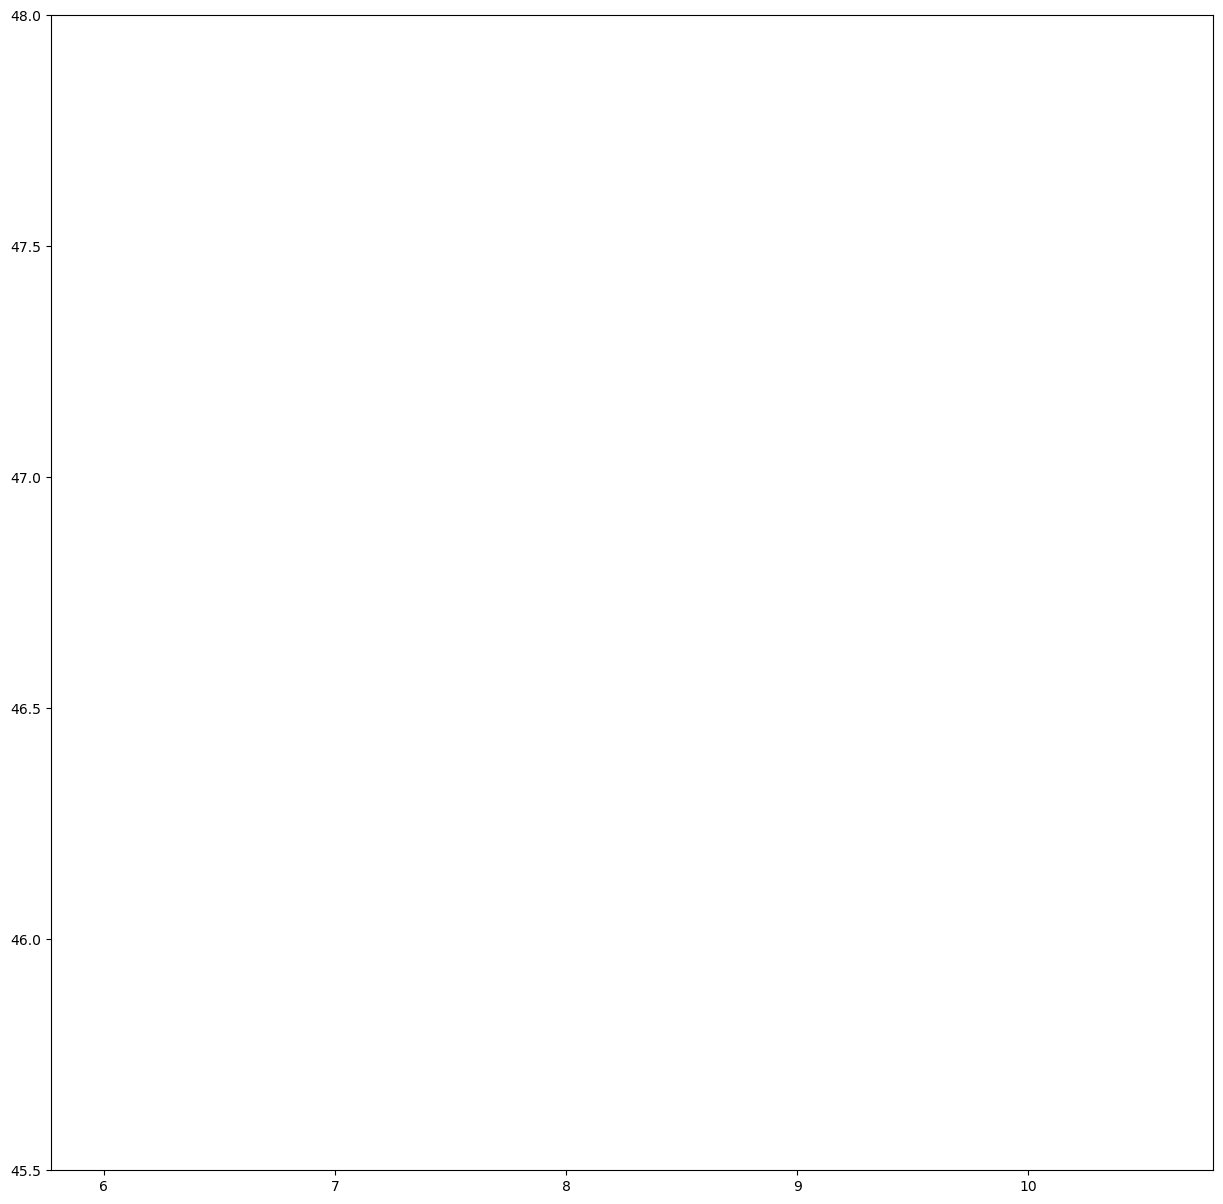

In [3]:
import matplotlib.pyplot as plt
import contextily as ctx
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

# Set the figure size
fig, ax = plt.subplots(figsize=(15, 15))


# Set the spatial extent
extent = extent_switzerland
#extent = Zurich_extent
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])

# Plot the original TRT cell geometries
#trt_gdf_with_buffer.plot(ax=ax, color='green', edgecolor='black', linewidth=1, label='TRT Cells', alpha=0.5)

# Convert trt_df to GeoDataFrame
trt_gdf_new = gpd.GeoDataFrame(trt_df, geometry='geometry')

# Plot the TRT cells with conditional coloring
trt_gdf_new.plot(ax=ax, color=trt_gdf_new['Gust_Flag'].map({'Yes': 'red', '-': 'green', 'No': 'blue'}), 
             edgecolor='black', linewidth=1, label='TRT Cells', alpha=0.5)

# Plot the buffer geometries
trt_gdf_buffer.plot(ax=ax, column='buffer_geometry', color='white', alpha=0.3, label='10km Buffer', edgecolor='black')

# Plot the buffer geometries
trt_gdf_small_buffer.plot(ax=ax, column='buffer_geometry', color='yellow', alpha=0.3, label='5km Buffer', edgecolor='black')

# Plot CS gust markers if not empty
if not gust_gdf_cs.empty:
    gust_gdf_cs.plot(ax=ax, color='black', markersize=50, label='CS Gust Markers', marker='*')

# Plot STA gust markers if not empty
if not gust_gdf_sta.empty:
    gust_gdf_sta.plot(ax=ax, color='black', markersize=40, label='STA Gust Markers', marker='o')

# Plot matched CS gust markers if not empty
if not matched_gusts_cs.empty:
    matched_gusts_cs.plot(ax=ax, color='red', markersize=50, label='CS Gust Markers within Cell', marker='*')

# Plot matched STA gust markers if not empty
if not matched_gusts_sta.empty:
    matched_gusts_sta.plot(ax=ax, color='blue', markersize=40, label='STA Gust Markers within 10km Buffer', marker='o')

# Plot the Zurich polygon
zurich_gdf.plot(ax=ax, facecolor='none', edgecolor='purple', linewidth=2, label='Zurich Area')

# Add a basemap
ctx.add_basemap(ax, crs=trt_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add title and legend
plt.title(f"TRT Cells and Matched Gust Markers at {target_datetime}, Buffers = 5 / 10 km", fontsize=16)
plt.legend(loc='upper left', fontsize=12)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.7)

# Add north arrow
x, y, arrow_length = 0.05, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

# Show the plot
plt.tight_layout()

#plt.savefig("/users/fackerma/newproject1/figures/negative_cases/Gust_Markers/2_" + day + '_' + valid_time3 + "_10km_spatprio_.png", dpi=300, bbox_inches='tight')


## TRT Flagging on 5 year period

In [8]:
# Flagging with negative, spatial prio and 5 / 10 km Buffer

import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import os
import datetime
from datetime import datetime, timedelta

# Define TRT reading function
def read_TRT(path, file=0, ttime=0):
    """
    Read .trt or .json file containing TRT output
    Returns dataframe with attributes and gridded TRT cells

    Parameters
    ----------

    path : string
        path, where to look for files.
    file: string
        filename
    ttime : string
        timestep to find files for.
    Requires either filename or timestep
   
    Returns
    -------
    trt_df : dataframe
        TRT cells and attributes of the timestep.
    cells: list
        Gridded TRT cells per timestep
    timelist: list
        timesteps

    """
   
    o_x=255000
    o_y=-160000
    lx=710; ly=640
    cells=np.zeros([ly,lx])
    if file == 0:
        file=glob.glob(path["lomdata"]+'*'+ttime+'*json*')
        if len(file)>0: flag=1
        else:
            file=glob.glob(path["lomdata"]+'*'+ttime+'*'+'.trt')[0]
            flag=0
    else:
        if 'json' in file: flag=1; ttime=file[-20:-11]
        else: flag=0; ttime=file[-15:-6]
        file=[file]
   
    if flag==1:
        with open(file[0]) as f: gj = geojson.FeatureCollection(gs.load(f))
        trt_df=geopandas.GeoDataFrame.from_features(gj['features'])
        if len(trt_df)>0:
          # print(trt_df.lon.values.astype(float))
          chx, chy = c_transform(trt_df.lon.values.astype(float),trt_df.lat.values.astype(float))
          trt_df['chx']=chx.astype(str); trt_df['chy']=chy.astype(str)
          for n in range(len(trt_df)):
              lon,lat=trt_df.iloc[n].geometry.boundary.xy
              # print(trt_df.iloc[n])
              chx, chy = c_transform(lon,lat)
              # trt_df.iloc[n]['chx']=chx.astype(str); trt_df.iloc[n]['chy']=chy.astype(str)
              #transform.c_transform(trt_df.iloc[n].lon.values,trt_df.iloc[n].lat.values)
              ix=np.round((chx-o_x)/1000).astype(int)
              iy=np.round((chy-o_y)/1000).astype(int)
              rr, cc = polygon(iy, ix, cells.shape)
              # print(lat,lon,chx,chy,ix,iy)
              cells[rr,cc]=int(trt_df.traj_ID.iloc[n]);
        else: cells=[]
    else:
        data = pd.read_csv(file).iloc[8:]
        headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
        trt_df = pd.DataFrame()
        geometries = []  # New list to store geometries

        for n in range(len(data)):
            # ... (existing code remains the same)
            t = data.iloc[n].str.split(';', expand=True)
            trt_df.loc[n, 'traj_ID'] = float(t.iloc[0, 0])
            #trt_df.loc[n, 'yyyymmddHHMM'] = int(t[1].values)
            trt_df.loc[n, 'yyyymmddHHMM'] = str(t[1].values[0])  # Assign as string
            trt_df.loc[n, 'lon'] = t[2].values.astype(float)
            trt_df.loc[n, 'lat'] = t[3].values.astype(float)
            trt_df.loc[n, 'ell_L'] = t[4].values.astype(float)
            trt_df.loc[n, 'ell_S'] = t[5].values.astype(float)
            trt_df.loc[n, 'ell_or'] = t[6].values.astype(float)
            trt_df.loc[n, 'area'] = t[7].values.astype(float)
            trt_df.loc[n, 'vel_x'] = t[8].values.astype(float)
            trt_df.loc[n, 'vel_y'] = t[9].values.astype(float)
            trt_df.loc[n, 'det'] = t[10].values.astype(float)
            trt_df.loc[n, 'RANKr'] = t[11].values.astype(float)
            trt_df.loc[n, 'CG-'] = t[12].values.astype(float)
            trt_df.loc[n, 'CG+'] = t[13].values.astype(float)
            trt_df.loc[n, 'CG'] = t[14].values.astype(float)
            trt_df.loc[n, '%CG+'] = t[15].values.astype(float)
            trt_df.loc[n, 'ET45'] = t[16].values.astype(float)
            trt_df.loc[n, 'ET45m'] = t[17].values.astype(float)
            trt_df.loc[n, 'ET15'] = t[18].values.astype(float)
            trt_df.loc[n, 'ET15m'] = t[19].values.astype(float)
            trt_df.loc[n, 'VIL'] = t[20].values.astype(float)
            trt_df.loc[n, 'maxH'] = t[21].values.astype(float)
            trt_df.loc[n, 'maxHm'] = t[22].values.astype(float)
            trt_df.loc[n, 'POH'] = t[23].values.astype(float)
            trt_df.loc[n, 'MESHS'] = t[24].values.astype(float)
            trt_df.loc[n, 'Dvel_x'] = t[25].values.astype(float)
            trt_df.loc[n, 'Dvel_y'] = t[26].values.astype(float)
            chx, chy = c_transform([trt_df.loc[n, 'lon']], [trt_df.loc[n, 'lat']])
            ix = np.round((chx - o_x) / 1000).astype(int)
            if ix >= 710: ix = 709
            iy = np.round((chy - o_y) / 1000).astype(int)
            if iy >= 640: iy = 639
            n2 = 27
            #if int(ttime) >= 221520631: n2 = 82
            tt = np.array(t)[0, n2:-1]
            tt = np.reshape(tt, [int(len(tt) / 2), 2])
            trt_df.loc[n, 'chx'] = chx
            trt_df.loc[n, 'chy'] = chy
            lat = tt[:, 1].astype(float)
            lon = tt[:, 0].astype(float)
            chx, chy = c_transform(lon, lat)
            ix = np.round((chx - o_x) / 1000).astype(int)
            iy = np.round((chy - o_y) / 1000).astype(int)
            rr, cc = polygon(iy, ix, cells.shape)
            cells[rr, cc] = int(t[0].values)
            # Create polygon for this cell
            polygon_coords = list(zip(lon, lat))
            cell_polygon = Polygon(polygon_coords)
            geometries.append(cell_polygon)
        
        # Add geometry column to trt_df
        trt_df['geometry'] = geometries
    
        # Convert trt_df to GeoDataFrame
        trt_df = gpd.GeoDataFrame(trt_df, geometry='geometry', crs="EPSG:4326")

    timelist=[str(ttime)]
    return trt_df, [cells], timelist


import zipfile

def process_gust_markers(valid_date3, valid_time3):
    # Convert time format and read TRT data
    # Convert valid_date3 to a datetime object
    date_obj = datetime.strptime(valid_date3, '%Y-%m-%d')
    # Extract the last two digits of the year and the day of the year
    year_last_two = date_obj.strftime('%y')  # Last two digits of the year
    day_of_year = date_obj.timetuple().tm_yday  # Day of the year (1-366)
    # Combine them into the desired format
    valid_date4 = f"{year_last_two}{day_of_year:03d}"  # Ensure day_of_year is zero-padded to 3 digits
    valid_time4 = valid_time3 + '0'
    #path_trtc = {"lomdata": "/scratch/mch/fackerma/orders/TRT_set"} 
    path_trtc = {"lomdata": "/scratch/mch/fackerma/orders/case_150619/TRTC/"} 
    #path_trtc = {"lomdata": "/scratch/mch/fackerma/orders/case_120721/TRTC/"}
    #path_trtc = {"lomdata": "/scratch/mch/fackerma/orders/case_130721/TRTC/"}
    #path_trtc = {"lomdata": "/scratch/mch/fackerma/orders/case_300622/TRTC/"}
    #path_trtc = {"lomdata": "/scratch/mch/fackerma/orders/case_240723/TRTC/"}
    #path_trtc = {"lomdata": "/scratch/mch/fackerma/orders/case_240823/TRTC/"}
    #path_trtc = {"lomdata": "/scratch/mch/fackerma/orders/negative_cases/case_040823/TRTC/"}   
    trt_df, cells_list, timelist = read_TRT(path_trtc, ttime=valid_date4+valid_time4)

    # Load the Gust Markers dataframe
    df = pd.read_pickle("/scratch/mch/fackerma/orders/Gust_Markers/Gust_Markers_3.pkl")

    # Check if trt_df is empty
    if trt_df.empty:
        # Create an empty DataFrame with the required columns
        empty_df = pd.DataFrame(columns=['geometry', 'CS Marker', 'STA Marker', 'ESWD Marker', 'Gust_Flag'])
        trt_df = empty_df.copy()
        return trt_df
    else:
        # Extract the larges 5 cities based on popdense > 1000 / km sqared
        file_path_swiss_cities = "polygons_wgs84_1000.gpkg"
        swiss_cities_gdf = gpd.read_file(file_path_swiss_cities)

        # Ensure yyyymmddHHMM and traj_ID are strings (to avoid float conversion issues)
        trt_df['yyyymmddHHMM'] = trt_df['yyyymmddHHMM'].astype(str)
        trt_df['yyyymmddHHMM'] = trt_df['yyyymmddHHMM'].str.strip()  # Remove leading/trailing spaces
        
        trt_df['traj_ID'] = trt_df['traj_ID'].astype(str)

        # Convert yyyymmddHHMM to datetime
        trt_df['current_time'] = pd.to_datetime(trt_df['yyyymmddHHMM'], format='%Y%m%d%H%M')

        # Extract birth time from the first 12 digits of traj_ID and convert to datetime
        #trt_df['birth_time'] = pd.to_datetime(trt_df['traj_ID'].str[:12], format='%Y%m%d%H%M')
        # Ensure traj_ID is string, extract first 12 characters, then convert to datetime
        trt_df['birth_time'] = pd.to_datetime(trt_df['traj_ID'].astype(str).str[:12], format='%Y%m%d%H%M')

        # Calculate age in minutes
        trt_df['Age'] = (trt_df['current_time'] - trt_df['birth_time']).dt.total_seconds() / 60

        # Optionally, drop helper columns
        trt_df.drop(columns=['current_time', 'birth_time'], inplace=True)

        # Convert trt_df to a GeoDataFrame and create buffer
        trt_gdf = GeoDataFrame(trt_df, geometry='geometry', crs="EPSG:4326")
        trt_gdf_projected = trt_gdf.to_crs(epsg=32632)
        trt_gdf_projected['buffer_geometry'] = trt_gdf_projected.geometry.buffer(10000)
        trt_gdf_with_buffer = trt_gdf_projected.to_crs(epsg=4326)
        trt_gdf_with_buffer['buffer_geometry'] = trt_gdf_with_buffer['buffer_geometry'].to_crs(epsg=4326)

        trt_gdf_small_buffer = trt_gdf.to_crs(epsg=32632)
        trt_gdf_small_buffer['buffer_geometry'] = trt_gdf_small_buffer.geometry.buffer(5000)
        trt_gdf_small_buffer = trt_gdf_small_buffer.to_crs(epsg=4326)
        trt_gdf_small_buffer['buffer_geometry'] = trt_gdf_small_buffer['buffer_geometry'].to_crs(epsg=4326)

        # Set up datetime for filtering
        datetime_string = f"{valid_date3} {valid_time3[:2]}:{valid_time3[2:]}:00"
        target_datetime = pd.to_datetime(datetime_string)
        time_window_cs = pd.Timedelta(minutes=2.5)
        time_window_sta = pd.Timedelta(minutes=5)
        time_window_eswd = pd.Timedelta(minutes=2.5)

        # Filter and process CS and STA data
        df_cs = df[df['Source'] == 'CS']
        df_sta = df[df['Source'] == 'STA'].copy()
        df_sta['Time'] = df_sta['Time'] - pd.Timedelta(minutes=5)
        df_eswd = df[df['Source'] == 'ESWD']

        filtered_df_cs = df_cs[(df_cs['Time'] >= target_datetime - time_window_cs) & 
                               (df_cs['Time'] <= target_datetime + time_window_cs)]
        filtered_df_sta = df_sta[(df_sta['Time'] >= target_datetime - time_window_sta) & 
                                 (df_sta['Time'] <= target_datetime + time_window_sta)]
        filtered_df_eswd = df_eswd[(df_eswd['Time'] >= target_datetime - time_window_eswd) & 
                                 (df_eswd['Time'] <= target_datetime + time_window_eswd)]

        # Convert to GeoDataFrames
        gust_gdf_cs = GeoDataFrame(filtered_df_cs, 
                                   geometry=gpd.points_from_xy(filtered_df_cs.Longitude, filtered_df_cs.Latitude),
                                   crs="EPSG:4326")
        gust_gdf_sta = GeoDataFrame(filtered_df_sta, 
                                    geometry=gpd.points_from_xy(filtered_df_sta.Longitude, filtered_df_sta.Latitude),
                                    crs="EPSG:4326")
        gust_gdf_eswd = GeoDataFrame(filtered_df_eswd, 
                                    geometry=gpd.points_from_xy(filtered_df_eswd.Longitude, filtered_df_eswd.Latitude),
                                    crs="EPSG:4326")

        # After creating trt_gdf_with_buffer:
        trt_gdf_buffer = trt_gdf_with_buffer.to_crs(epsg=4326)  # Ensure CRS matches gust_gdf_sta
        trt_gdf_buffer.set_geometry('buffer_geometry', inplace=True)
        trt_gdf_buffer['buffer_geometry'] = trt_gdf_buffer['buffer_geometry'].to_crs(epsg=4326)

        # Perform spatial joins for CS gusts
        #trt_gdf_buffer = trt_gdf_with_buffer.copy()
        #trt_gdf_buffer.set_geometry('buffer_geometry', inplace=True)
        trt_gdf_small_buffer.set_geometry('buffer_geometry', inplace=True)
        
        # For CS data
        matched_gusts_cs = gpd.sjoin(gust_gdf_cs, trt_gdf_small_buffer, how="inner", predicate="within", rsuffix='_trt')
        matched_gusts_cs = matched_gusts_cs.sort_values(by=['Age', 'RANKr'], ascending=[False, False]).drop_duplicates(subset=['Longitude', 'Latitude', 'Time'], keep='first')

        # For STA data
        matched_gusts_sta = gpd.sjoin(gust_gdf_sta, trt_gdf_buffer, how="inner", predicate="within", rsuffix='_trt')
        matched_gusts_sta = matched_gusts_sta.sort_values(by=['Age', 'RANKr'], ascending=[False, False]).drop_duplicates(subset=['Longitude', 'Latitude', 'Time'], keep='first')

        # For ESWD data
        matched_gusts_eswd = gpd.sjoin(gust_gdf_eswd, trt_gdf_small_buffer, how="inner", predicate="within", rsuffix='_trt')
        matched_gusts_eswd = matched_gusts_eswd.sort_values(by=['Age', 'RANKr'], ascending=[False, False]).drop_duplicates(subset=['Longitude', 'Latitude', 'Time'], keep='first')


        # CS markers
        cs_counts = matched_gusts_cs['traj_ID'].value_counts().to_dict()
        trt_df['CS Marker'] = trt_df['traj_ID'].map(cs_counts).fillna(0).astype(int)

        # STA markers
        sta_counts = matched_gusts_sta['traj_ID'].value_counts().to_dict()
        trt_df['STA Marker'] = trt_df['traj_ID'].map(sta_counts).fillna(0).astype(int)

        # ESWD markers
        eswd_counts = matched_gusts_eswd['traj_ID'].value_counts().to_dict()
        trt_df['ESWD Marker'] = trt_df['traj_ID'].map(eswd_counts).fillna(0).astype(int)

        # Initialize 'STA Speed' column
        trt_df['STA Speed'] = None

        # Collect wind speeds for each traj_ID
        sta_speeds = matched_gusts_sta.groupby('traj_ID')['Attribute'].apply(list).to_dict()
        cs_attribute = matched_gusts_cs.groupby('traj_ID')['Attribute'].apply(list).to_dict()

        def combine_attributes(traj_id):
            sta = sta_speeds.get(traj_id, [])
            cs = cs_attribute.get(traj_id, [])
            combined = sta + cs
            if len(combined) == 1:
                return combined[0]
            return combined
        
        trt_df['STA Speed'] = trt_df['traj_ID'].apply(combine_attributes)

        # Map the collected wind speeds to the 'STA Speed' column
        #trt_df['STA Speed'] = trt_df['traj_ID'].map(sta_speeds)

        # Convert lists with a single element to just that element
        #trt_df['STA Speed'] = trt_df['STA Speed'].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)



        # Create a new geometry column in trt_gdf based on lon and lat
        trt_gdf['point_geometry'] = trt_gdf.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

        # Perform the intersection check using the new point_geometry column
        touches_swiss_cities = trt_gdf['point_geometry'].apply(
            lambda point: swiss_cities_gdf.intersects(point).any()
        )
        
        # Assign 'Gust_Flag' based on conditions
        trt_df['Gust_Flag'] = np.where(
            (trt_df['CS Marker'] > 1) | (trt_df['STA Marker'] > 0) | (trt_df['ESWD Marker'] > 0),
            'Yes',
            np.where(
                (touches_swiss_cities) &
                (target_datetime.time() >= datetime.strptime("04:00:00", "%H:%M:%S").time()) &
                (target_datetime.time() <= datetime.strptime("20:00:00", "%H:%M:%S").time()) &
                (target_datetime.year in [2022, 2023]) &
                (trt_df['CS Marker'] == 0) &
                (trt_df['STA Marker'] == 0) &
                (trt_df['ESWD Marker'] == 0),
                'No',
                '-'
            )
        )



        
    #return trt_df
    return trt_df, gust_gdf_cs, gust_gdf_sta, gust_gdf_eswd, trt_gdf_with_buffer, trt_gdf_buffer, matched_gusts_sta, matched_gusts_cs, matched_gusts_eswd, trt_gdf, target_datetime, trt_gdf_small_buffer, cs_counts, sta_counts, eswd_counts, timelist, swiss_cities_gdf

#def process_gust_markers(valid_date3, valid_time3, extraction_dir):
    # Convert date/time parameters
    date_obj = datetime.strptime(valid_date3, '%Y-%m-%d')
    year_last_two = date_obj.strftime('%y')
    day_of_year = date_obj.timetuple().tm_yday
    valid_date4 = f"{year_last_two}{day_of_year:03d}"
    valid_time4 = valid_time3 + '0'

    # Find matching TRT data file in extraction directory
    target_pattern = f"CZC{valid_date4}{valid_time4}"
    trt_data_file = next((f for f in os.listdir(extraction_dir) 
                         if f.startswith(target_pattern)), None)

    if not trt_data_file:
        return pd.DataFrame(columns=['geometry', 'CS Marker', 'STA Marker', 
                                   'ESWD Marker', 'STA Speed', 'Gust_Flag'])

    trt_data_path = extraction_dir
    
    # Attempt to read TRT data and handle errors gracefully
    try:
        trt_df, cells_list, timelist = read_TRT({"lomdata": trt_data_path}, 
                                                ttime=valid_date4+valid_time4)
    except Exception as e:
        # Log the error if needed (optional)
        print(f"Error reading TRT data: {e}")
        # Return an empty DataFrame with required columns
        return pd.DataFrame(columns=['geometry', 'CS Marker', 'STA Marker', 
                                     'ESWD Marker', 'STA Speed', 'Gust_Flag'])
    
    # Load Gust Markers dataframe
    df = pd.read_pickle("/scratch/mch/fackerma/orders/Gust_Markers/Gust_Markers_3.pkl")
        
    if trt_df.empty:
        # Return an empty DataFrame with required columns if TRT data is empty
        empty_df = pd.DataFrame(columns=['geometry', 'CS Marker', 'STA Marker', 'ESWD Marker', 'STA Speed', 'Gust_Flag'])
        trt_df = empty_df
        return trt_df
        

    # Alternative: Extract the larges 5 cities based on popdense > 2000 / km sqared
    file_path_swiss_cities = "polygons_wgs84_1000.gpkg"
    # Read the GeoPackage into a GeoDataFrame
    swiss_cities_gdf = gpd.read_file(file_path_swiss_cities)
        
    # Convert TRT DataFrame to GeoDataFrame and process buffers
    trt_gdf = GeoDataFrame(trt_df, geometry='geometry', crs="EPSG:4326")

    trt_gdf_projected = trt_gdf.to_crs(epsg=32632)
    trt_gdf_projected['buffer_geometry'] = trt_gdf_projected.geometry.buffer(10000)
    trt_gdf_with_buffer = trt_gdf_projected.to_crs(epsg=4326)
        
    trt_gdf_small_buffer = trt_gdf.to_crs(epsg=32632)
    trt_gdf_small_buffer['buffer_geometry'] = trt_gdf_small_buffer.geometry.buffer(5000)
    trt_gdf_small_buffer = trt_gdf_small_buffer.to_crs(epsg=4326)
    trt_gdf_small_buffer['buffer_geometry'] = trt_gdf_small_buffer['buffer_geometry'].to_crs(epsg=4326)

    # Set up datetime for filtering
    datetime_string = f"{valid_date3} {valid_time3[:2]}:{valid_time3[2:]}:00"
    target_datetime = pd.to_datetime(datetime_string)
    time_window_cs = pd.Timedelta(minutes=2.5)
    time_window_sta = pd.Timedelta(minutes=5)
    time_window_eswd = pd.Timedelta(minutes=2.5)

    # Filter and process CS and STA data
    df_cs = df[df['Source'] == 'CS']
    df_sta = df[df['Source'] == 'STA'].copy()
    df_sta['Time'] = df_sta['Time'] - pd.Timedelta(minutes=5)
    df_eswd = df[df['Source'] == 'ESWD']

    filtered_df_cs = df_cs[(df_cs['Time'] >= target_datetime - time_window_cs) & 
                           (df_cs['Time'] <= target_datetime + time_window_cs)]
    filtered_df_sta = df_sta[(df_sta['Time'] >= target_datetime - time_window_sta) & 
                            (df_sta['Time'] <= target_datetime + time_window_sta)]
    filtered_df_eswd = df_eswd[(df_eswd['Time'] >= target_datetime - time_window_eswd) & 
                            (df_eswd['Time'] <= target_datetime + time_window_eswd)]

    # Convert to GeoDataFrames
    gust_gdf_cs = GeoDataFrame(filtered_df_cs, 
                               geometry=gpd.points_from_xy(filtered_df_cs.Longitude, filtered_df_cs.Latitude),
                               crs="EPSG:4326")
    gust_gdf_sta = GeoDataFrame(filtered_df_sta, 
                               geometry=gpd.points_from_xy(filtered_df_sta.Longitude, filtered_df_sta.Latitude),
                               crs="EPSG:4326")
    gust_gdf_eswd = GeoDataFrame(filtered_df_eswd, 
                                geometry=gpd.points_from_xy(filtered_df_eswd.Longitude, filtered_df_eswd.Latitude),
                                crs="EPSG:4326")

    # After creating trt_gdf_with_buffer:
    trt_gdf_buffer = trt_gdf_with_buffer.to_crs(epsg=4326)  # Ensure CRS matches gust_gdf_sta
    trt_gdf_buffer.set_geometry('buffer_geometry', inplace=True)
    trt_gdf_buffer['buffer_geometry'] = trt_gdf_buffer['buffer_geometry'].to_crs(epsg=4326)

    # Perform spatial joins for CS gusts
    #trt_gdf_buffer = trt_gdf_with_buffer.copy()
    #trt_gdf_buffer.set_geometry('buffer_geometry', inplace=True)
    trt_gdf_small_buffer.set_geometry('buffer_geometry', inplace=True)

    #trt_gdf_buffer = trt_gdf_with_buffer.copy()
    #trt_gdf_buffer.set_geometry('buffer_geometry', inplace=True)

    matched_gusts_cs = gpd.sjoin(gust_gdf_cs, trt_gdf_small_buffer, how="inner", predicate="within", rsuffix='_trt')
    matched_gusts_cs = matched_gusts_cs.drop_duplicates(subset=['Longitude', 'Latitude', 'Time'], keep='first')
        
    matched_gusts_sta = gpd.sjoin(gust_gdf_sta, trt_gdf_buffer, how="inner", predicate="within", rsuffix='_trt')
    matched_gusts_sta = matched_gusts_sta.drop_duplicates(subset=['Longitude', 'Latitude', 'Time'], keep='first')

    matched_gusts_eswd = gpd.sjoin(gust_gdf_eswd, trt_gdf_small_buffer, how="inner", predicate="within", rsuffix='_trt')
    matched_gusts_eswd = matched_gusts_eswd.drop_duplicates(subset=['Longitude', 'Latitude', 'Time'], keep='first')

    # For STA gusts, find the closest cell
    def find_closest_cell(gust_point, cells_gdf):
        distances = cells_gdf.geometry.distance(gust_point)
        closest_cell_index = distances.idxmin()
        return closest_cell_index, distances[closest_cell_index]

    sta_closest_cells = matched_gusts_sta.geometry.apply(lambda x: find_closest_cell(x, trt_gdf))
    cs_closest_cells = matched_gusts_cs.geometry.apply(lambda x: find_closest_cell(x, trt_gdf))
    eswd_closest_cells = matched_gusts_eswd.geometry.apply(lambda x: find_closest_cell(x, trt_gdf))

    sta_closest_df = pd.DataFrame(sta_closest_cells.tolist(), columns=['traj_ID', 'distance'], index=sta_closest_cells.index)
    #sta_closest_df.drop_duplicates(subset=['traj_ID', 'distance'], inplace=True)
    cs_closest_df = pd.DataFrame(cs_closest_cells.tolist(), columns=['traj_ID', 'distance'], index=cs_closest_cells.index)

    eswd_closest_df = pd.DataFrame(eswd_closest_cells.tolist(), columns=['traj_ID', 'distance'], index=eswd_closest_cells.index)

    cs_counts = {}
    for index, row in cs_closest_df.iterrows():
        if row['distance'] <= 5000:
            cs_counts[row['traj_ID']] = cs_counts.get(row['traj_ID'], 0) + 1

    sta_counts = {}
    for index, row in sta_closest_df.iterrows():
        if row['distance'] <= 10000:
            sta_counts[row['traj_ID']] = sta_counts.get(row['traj_ID'], 0) + 1

    eswd_counts = {}
    for index, row in eswd_closest_df.iterrows():
        if row['distance'] <= 5000:
            eswd_counts[row['traj_ID']] = eswd_counts.get(row['traj_ID'], 0) + 1

    # Update trt_df with the new counts
    trt_df['CS Marker'] = trt_df.index.map(lambda x: cs_counts.get(x, 0)).fillna(0).astype(int)
    trt_df['STA Marker'] = trt_df.index.map(lambda x: sta_counts.get(x, 0)).fillna(0).astype(int)
    trt_df['ESWD Marker'] = trt_df.index.map(lambda x: eswd_counts.get(x, 0)).fillna(0).astype(int)

    touches_zurich = trt_gdf.intersects(zurich_gdf.geometry.iloc[0])

    # Create a new geometry column in trt_gdf based on lon and lat
    trt_gdf['point_geometry'] = trt_gdf.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

    # Perform the intersection check using the new point_geometry column
    touches_swiss_cities = trt_gdf['point_geometry'].apply(
        lambda point: swiss_cities_gdf.intersects(point).any()
    )
    
    # Assign 'Gust_Flag' based on conditions
    trt_df['Gust_Flag'] = np.where(
        (trt_df['CS Marker'] > 1) | (trt_df['STA Marker'] > 0) | (trt_df['ESWD Marker'] > 0),
        'Yes',
        np.where(
            (touches_swiss_cities) &
            (target_datetime.time() >= datetime.strptime("04:00:00", "%H:%M:%S").time()) &
            (target_datetime.time() <= datetime.strptime("20:00:00", "%H:%M:%S").time()) &
            (target_datetime.year in [2022, 2023]) &
            (trt_df['CS Marker'] == 0) &
            (trt_df['STA Marker'] == 0) &
            (trt_df['ESWD Marker'] == 0),
            'No',
            '-'
        )
    )

    #return trt_df
    return trt_df, gust_gdf_cs, gust_gdf_sta, gust_gdf_eswd, trt_gdf_with_buffer, trt_gdf_buffer, matched_gusts_sta, matched_gusts_cs, matched_gusts_eswd, trt_gdf, target_datetime, sta_closest_df, sta_closest_cells, eswd_closest_df, eswd_closest_cells, zurich_gdf, touches_zurich, trt_gdf_small_buffer, cs_counts, sta_counts, eswd_counts, cs_closest_df, timelist, cs_closest_cells, swiss_cities_gdf

In [9]:

# Process a trt_df file
valid_date3 = '2019-06-15'
valid_time3 = '1540'

#trt_df = process_gust_markers(valid_date3, valid_time3)
trt_df, gust_gdf_cs, gust_gdf_sta, gust_gdf_eswd, trt_gdf_with_buffer, trt_gdf_buffer, matched_gusts_sta, matched_gusts_cs, matched_gusts_eswd, trt_gdf, target_datetime, trt_gdf_small_buffer, cs_counts, sta_counts, eswd_counts,  timelist,  swiss_cities_gdf = process_gust_markers(valid_date3, valid_time3)



/tmp/ipykernel_126148/4133805828.py:75: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
/tmp/ipykernel_126148/4133805828.py:127: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cells[rr, cc] = int(t[0].values)
/tmp/ipykernel_126148/4133805828.py:127: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cells[rr, cc] = int(t[0].values)
/tmp/ipykernel_126148/4133805828.py:127: DeprecationWarning: Conversion of 

/tmp/ipykernel_260547/926455609.py:40: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  trt_gdf_buffer.plot(ax=ax, column='buffer_geometry', color='white', alpha=0.3, label='10km Buffer', edgecolor='black')
/tmp/ipykernel_260547/926455609.py:43: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  trt_gdf_small_buffer.plot(ax=ax, column='buffer_geometry', color='yellow', alpha=0.3, label='5km Buffer', edgecolor='black')
/tmp/ipykernel_260547/926455609.py:46: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  swiss_cities_gdf.plot(ax=ax, column='geometry', color='grey', alpha=0.3, edgecolor='grey')
/tmp/ipykernel_260547/926455609.py:130: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper left', fontsize=20)


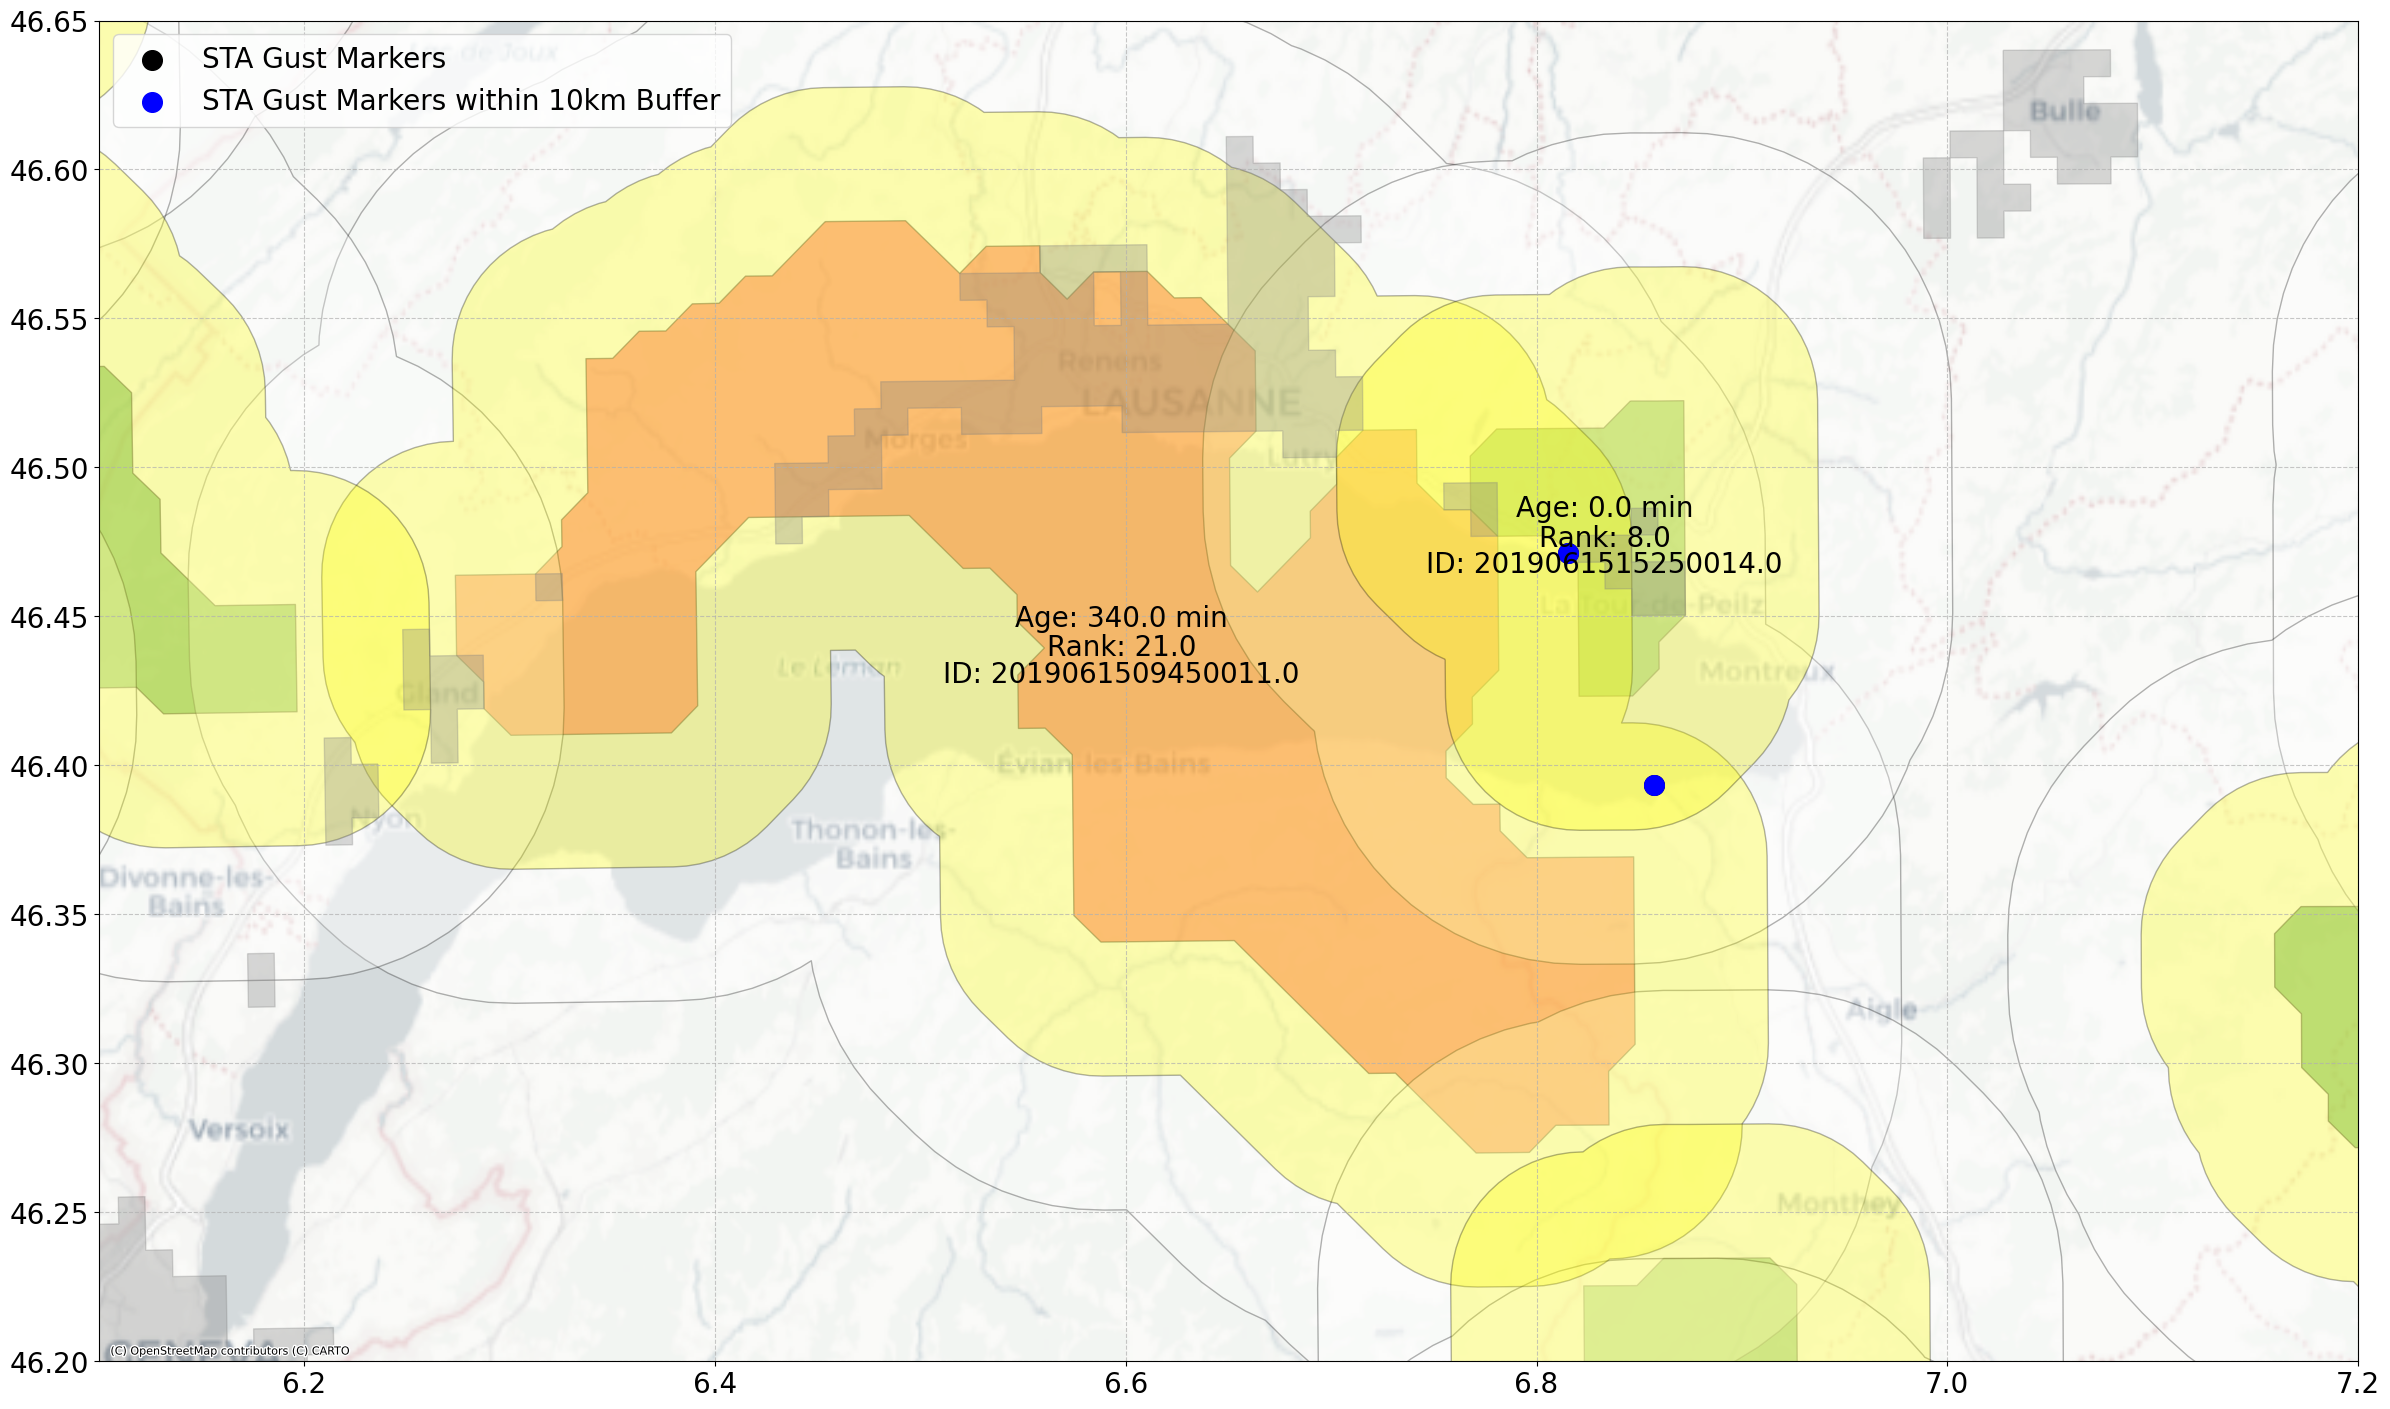

In [11]:
import matplotlib.pyplot as plt
import contextily as ctx
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

# Set the figure size
fig, ax = plt.subplots(figsize=(24, 20))

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

# Set the spatial extent
EastSwitzrelandLarge_extent = [6.3, 11, 46.3, 48.3]
EastSwitzreland_extent = [7.5, 10.2, 46.8, 48.0]
Lucerne_extent = [6.87, 8.7, 46.65, 47.4]
Schaffhausen_extent = [8.3, 9.1, 47.4, 47.8]
LakeGeneva_extent = [6.1, 7.2, 46.2, 46.65]
#extent = extent_switzerland
#extent = Lucerne_extent
extent = LakeGeneva_extent

ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])

# Plot the original TRT cell geometries
#trt_gdf_with_buffer.plot(ax=ax, color='green', edgecolor='black', linewidth=1, label='TRT Cells', alpha=0.5)

trt_df['lon'] = pd.to_numeric(trt_df['lon'], errors='coerce')
trt_df['lat'] = pd.to_numeric(trt_df['lat'], errors='coerce')


# Convert trt_df to GeoDataFrame
trt_gdf_new = gpd.GeoDataFrame(trt_df, geometry='geometry')

# Plot the TRT cells with conditional coloring
trt_gdf_new.plot(ax=ax, color=trt_gdf_new['Gust_Flag'].map({'Yes': 'red', '-': 'green', 'No': 'blue'}), 
             edgecolor='black', linewidth=1, label='TRT Cells', alpha=0.5)

# Plot the buffer geometries
trt_gdf_buffer.plot(ax=ax, column='buffer_geometry', color='white', alpha=0.3, label='10km Buffer', edgecolor='black')

# Plot the buffer geometries
trt_gdf_small_buffer.plot(ax=ax, column='buffer_geometry', color='yellow', alpha=0.3, label='5km Buffer', edgecolor='black')


swiss_cities_gdf.plot(ax=ax, column='geometry', color='grey', alpha=0.3, edgecolor='grey')
# Correct: Do not specify 'column' if you only want to plot the geometries
#swiss_cities_gdf.plot(ax=ax, color=None, alpha=0.5, edgecolor='purple')



# Add labels with strategic offsets (insert before plt.tight_layout())
for idx, row in trt_gdf_new.iterrows():
    x_center = row['lon']
    y_center = row['lat']
    
    # Age label: upper left offset
    ax.annotate(f"Age: {row['Age']:.1f} min", 
                (x_center, y_center),
                xytext=(0, 4),  # 15 points left, 8 points up
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=20,
                color='black',
                bbox=dict(boxstyle="round,pad=0.3",
                          facecolor='white',
                          edgecolor='none',
                          alpha=0))
    
    # RANKr label: lower right offset 
    ax.annotate(f"Rank: {row['RANKr']}", 
                (x_center, y_center),
                xytext=(0, 3),  # 12 points right, 10 points down
                textcoords="offset points",
                ha='center', va='top',
                fontsize=20,
                color='black',
                bbox=dict(boxstyle="round,pad=0.3",
                          facecolor='white',
                          edgecolor='none',
                          alpha=0))

    ax.annotate(f"ID: {row['traj_ID']}", 
                (x_center, y_center),
                xytext=(0, -16),  # 12 points right, 10 points down
                textcoords="offset points",
                ha='center', va='top',
                fontsize=20,
                color='black',
                bbox=dict(boxstyle="round,pad=0.3",
                          facecolor='white',
                          edgecolor='none',
                          alpha=0))

# Plot CS gust markers if not empty
if not gust_gdf_cs.empty:
    gust_gdf_cs.plot(ax=ax, color='black', markersize=200, label='CS Gust Markers', marker='*')

# Plot STA gust markers if not empty
if not gust_gdf_sta.empty:
    gust_gdf_sta.plot(ax=ax, color='black', markersize=200, label='STA Gust Markers', marker='o')

# Plot STA gust markers if not empty
if not gust_gdf_eswd.empty:
    gust_gdf_eswd.plot(ax=ax, color='black', markersize=200, label='ESWD Gust Markers', marker='s')

# Plot matched CS gust markers if not empty
if not matched_gusts_cs.empty:
    matched_gusts_cs.plot(ax=ax, color='red', markersize=200, label='CS Gust Markers within 5km Buffer', marker='*')

# Plot matched STA gust markers if not empty
if not matched_gusts_sta.empty:
    matched_gusts_sta.plot(ax=ax, color='blue', markersize=200, label='STA Gust Markers within 10km Buffer', marker='o')

# Plot matched STA gust markers if not empty
if not matched_gusts_eswd.empty:
    matched_gusts_eswd.plot(ax=ax, color='orange', markersize=200, label='ESWD Gust Markers within 10km Buffer', marker='s')


# Plot the Zurich polygon
#zurich_gdf.plot(ax=ax, facecolor='none', edgecolor='purple', linewidth=2, label='Zurich Area')

#swiss_cities_gdf.plot(ax=ax, facecolor='none', edgecolor='purple', linewidth=2, label='Dense Area')

# Add a basemap
ctx.add_basemap(ax, crs=trt_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add title and legend
#plt.title(f"TRT Cells and Matched Gust Markers at {target_datetime}, Buffers = 5 / 10 km", fontsize=16)
plt.legend(loc='upper left', fontsize=20)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.7)

# Add north arrow
#x, y, arrow_length = 0.05, 0.95, 0.1
#ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            #arrowprops=dict(facecolor='black', width=5, headwidth=15),
            #ha='center', va='center', fontsize=20,
            #xycoords=ax.transAxes)

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

# Show the plot
plt.tight_layout()

#plt.savefig("/users/fackerma/newproject1/figures/Gust_Markers/Final_AgeRank_" + valid_date3 + '_' + valid_time3 + "_.png", dpi=300, bbox_inches='tight')


In [5]:

# Define TRT reading function
def read_TRT(path, file=0, ttime=0):
    """
    Read .trt or .json file containing TRT output
    Returns dataframe with attributes and gridded TRT cells

    Parameters
    ----------

    path : string
        path, where to look for files.
    file: string
        filename
    ttime : string
        timestep to find files for.
    Requires either filename or timestep
   
    Returns
    -------
    trt_df : dataframe
        TRT cells and attributes of the timestep.
    cells: list
        Gridded TRT cells per timestep
    timelist: list
        timesteps

    """
   
    o_x=255000
    o_y=-160000
    lx=710; ly=640
    cells=np.zeros([ly,lx])
    if file == 0:
        file=glob.glob(path["lomdata"]+'*'+ttime+'*json*')
        if len(file)>0: flag=1
        else:
            file=glob.glob(path["lomdata"]+'*'+ttime+'*'+'.trt')[0]
            flag=0
    else:
        if 'json' in file: flag=1; ttime=file[-20:-11]
        else: flag=0; ttime=file[-15:-6]
        file=[file]
   
    if flag==1:
        with open(file[0]) as f: gj = geojson.FeatureCollection(gs.load(f))
        trt_df=geopandas.GeoDataFrame.from_features(gj['features'])
        if len(trt_df)>0:
          # print(trt_df.lon.values.astype(float))
          chx, chy = c_transform(trt_df.lon.values.astype(float),trt_df.lat.values.astype(float))
          trt_df['chx']=chx.astype(str); trt_df['chy']=chy.astype(str)
          for n in range(len(trt_df)):
              lon,lat=trt_df.iloc[n].geometry.boundary.xy
              # print(trt_df.iloc[n])
              chx, chy = c_transform(lon,lat)
              # trt_df.iloc[n]['chx']=chx.astype(str); trt_df.iloc[n]['chy']=chy.astype(str)
              #transform.c_transform(trt_df.iloc[n].lon.values,trt_df.iloc[n].lat.values)
              ix=np.round((chx-o_x)/1000).astype(int)
              iy=np.round((chy-o_y)/1000).astype(int)
              rr, cc = polygon(iy, ix, cells.shape)
              # print(lat,lon,chx,chy,ix,iy)
              cells[rr,cc]=int(trt_df.traj_ID.iloc[n]);
        else: cells=[]
    else:
        data = pd.read_csv(file).iloc[8:]
        headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
        trt_df = pd.DataFrame()
        geometries = []  # New list to store geometries

        for n in range(len(data)):
            # ... (existing code remains the same)
            t = data.iloc[n].str.split(';', expand=True)
            trt_df.loc[n, 'traj_ID'] = str(t[0].values)
            #trt_df.loc[n, 'yyyymmddHHMM'] = int(t[1].values)
            trt_df.loc[n, 'yyyymmddHHMM'] = str(t[1].values[0])  # Assign as string
            trt_df.loc[n, 'lon'] = t[2].values.astype(float)
            trt_df.loc[n, 'lat'] = t[3].values.astype(float)
            trt_df.loc[n, 'ell_L'] = t[4].values.astype(float)
            trt_df.loc[n, 'ell_S'] = t[5].values.astype(float)
            trt_df.loc[n, 'ell_or'] = t[6].values.astype(float)
            trt_df.loc[n, 'area'] = t[7].values.astype(float)
            trt_df.loc[n, 'vel_x'] = t[8].values.astype(float)
            trt_df.loc[n, 'vel_y'] = t[9].values.astype(float)
            trt_df.loc[n, 'det'] = t[10].values.astype(float)
            trt_df.loc[n, 'RANKr'] = t[11].values.astype(float)
            trt_df.loc[n, 'CG-'] = t[12].values.astype(float)
            trt_df.loc[n, 'CG+'] = t[13].values.astype(float)
            trt_df.loc[n, 'CG'] = t[14].values.astype(float)
            trt_df.loc[n, '%CG+'] = t[15].values.astype(float)
            trt_df.loc[n, 'ET45'] = t[16].values.astype(float)
            trt_df.loc[n, 'ET45m'] = t[17].values.astype(float)
            trt_df.loc[n, 'ET15'] = t[18].values.astype(float)
            trt_df.loc[n, 'ET15m'] = t[19].values.astype(float)
            trt_df.loc[n, 'VIL'] = t[20].values.astype(float)
            trt_df.loc[n, 'maxH'] = t[21].values.astype(float)
            trt_df.loc[n, 'maxHm'] = t[22].values.astype(float)
            trt_df.loc[n, 'POH'] = t[23].values.astype(float)
            trt_df.loc[n, 'MESHS'] = t[24].values.astype(float)
            trt_df.loc[n, 'Dvel_x'] = t[25].values.astype(float)
            trt_df.loc[n, 'Dvel_y'] = t[26].values.astype(float)
            chx, chy = c_transform([trt_df.loc[n, 'lon']], [trt_df.loc[n, 'lat']])
            ix = np.round((chx - o_x) / 1000).astype(int)
            if ix >= 710: ix = 709
            iy = np.round((chy - o_y) / 1000).astype(int)
            if iy >= 640: iy = 639
            n2 = 27
            #if int(ttime) >= 221520631: n2 = 82
            tt = np.array(t)[0, n2:-1]
            tt = np.reshape(tt, [int(len(tt) / 2), 2])
            trt_df.loc[n, 'chx'] = chx
            trt_df.loc[n, 'chy'] = chy
            lat = tt[:, 1].astype(float)
            lon = tt[:, 0].astype(float)
            chx, chy = c_transform(lon, lat)
            ix = np.round((chx - o_x) / 1000).astype(int)
            iy = np.round((chy - o_y) / 1000).astype(int)
            rr, cc = polygon(iy, ix, cells.shape)
            cells[rr, cc] = int(t[0].values)
            # Create polygon for this cell
            polygon_coords = list(zip(lon, lat))
            cell_polygon = Polygon(polygon_coords)
            geometries.append(cell_polygon)
        
        # Add geometry column to trt_df
        trt_df['geometry'] = geometries
    
        # Convert trt_df to GeoDataFrame
        trt_df = gpd.GeoDataFrame(trt_df, geometry='geometry', crs="EPSG:4326")

    timelist=[str(ttime)]
    return trt_df, [cells], timelist



In [55]:
# Filter trt_gdf_new based on marker conditions
filtered_trt = trt_gdf_new[(trt_gdf_new['CS Marker'] > 0) | (trt_gdf_new['STA Marker'] > 0) | (trt_gdf_new['ESWD Marker'] > 0)]

# Display the filtered DataFrame
print(filtered_trt)


                                             geometry           traj_ID  \
8   POLYGON ((8.4785 47.4006, 8.4651 47.3918, 8.42...  2023082417300207   
12  POLYGON ((8.4973 47.6793, 8.4968 47.6523, 8.52...  2023082417450212   
13  POLYGON ((8.6821 47.6055, 8.655 47.5878, 8.641...  2023082418000057   
14  POLYGON ((8.1343 47.4122, 8.1339 47.3852, 8.12...  2023082418000020   
16  POLYGON ((9.3088 47.2732, 9.2953 47.2644, 9.25...  2023082416200211   
24  POLYGON ((8.5126 47.7781, 8.5121 47.7511, 8.53...  2023082417500224   
25  POLYGON ((8.1893 47.5558, 8.1759 47.5469, 8.16...  2023082417350019   
26  POLYGON ((8.4939 47.5084, 8.467 47.4907, 8.466...  2023082418000152   
27  POLYGON ((8.5025 47.2745, 8.4891 47.2656, 8.47...  2023082418050113   

    yyyymmddHHMM     lon      lat  ell_L  ell_S ell_or area  vel_x  ...  \
8   202308241805  8.3417  47.1727  24.17  12.47   10.3  488  46.39  ...   
12  202308241805  8.5578  47.6160   7.24   3.75  133.5   36  49.99  ...   
13  202308241805  8.6770

In [11]:
trt_df.columns

Index(['traj_ID', 'yyyymmddHHMM', 'lon', 'lat', 'ell_L', 'ell_S', 'ell_or',
       'area', 'vel_x', 'vel_y', 'det', 'RANKr', 'CG-', 'CG+', 'CG', '%CG+',
       'ET45', 'ET45m', 'ET15', 'ET15m', 'VIL', 'maxH', 'maxHm', 'POH',
       'MESHS', 'Dvel_x', 'Dvel_y', 'chx', 'chy', 'geometry', 'Age',
       'CS Marker', 'STA Marker', 'ESWD Marker', 'STA Speed', 'Gust_Flag'],
      dtype='object')

## Final Processing Loop

In [ ]:
# Flagging with negative, spatial prio and 5 / 10 km Buffer

import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import os
import datetime
from datetime import datetime, timedelta

# Define TRT reading function
def read_TRT(path, file=0, ttime=0):
    """
    Read .trt or .json file containing TRT output
    Returns dataframe with attributes and gridded TRT cells

    Parameters
    ----------

    path : string
        path, where to look for files.
    file: string
        filename
    ttime : string
        timestep to find files for.
    Requires either filename or timestep
   
    Returns
    -------
    trt_df : dataframe
        TRT cells and attributes of the timestep.
    cells: list
        Gridded TRT cells per timestep
    timelist: list
        timesteps

    """
   
    o_x=255000
    o_y=-160000
    lx=710; ly=640
    cells=np.zeros([ly,lx])
    if file == 0:
        file=glob.glob(path["lomdata"]+'*'+ttime+'*json*')
        if len(file)>0: flag=1
        else:
            file=glob.glob(path["lomdata"]+'*'+ttime+'*'+'.trt')[0]
            flag=0
    else:
        if 'json' in file: flag=1; ttime=file[-20:-11]
        else: flag=0; ttime=file[-15:-6]
        file=[file]
   
    if flag==1:
        with open(file[0]) as f: gj = geojson.FeatureCollection(gs.load(f))
        trt_df=geopandas.GeoDataFrame.from_features(gj['features'])
        if len(trt_df)>0:
          # print(trt_df.lon.values.astype(float))
          chx, chy = c_transform(trt_df.lon.values.astype(float),trt_df.lat.values.astype(float))
          trt_df['chx']=chx.astype(str); trt_df['chy']=chy.astype(str)
          for n in range(len(trt_df)):
              lon,lat=trt_df.iloc[n].geometry.boundary.xy
              # print(trt_df.iloc[n])
              chx, chy = c_transform(lon,lat)
              # trt_df.iloc[n]['chx']=chx.astype(str); trt_df.iloc[n]['chy']=chy.astype(str)
              #transform.c_transform(trt_df.iloc[n].lon.values,trt_df.iloc[n].lat.values)
              ix=np.round((chx-o_x)/1000).astype(int)
              iy=np.round((chy-o_y)/1000).astype(int)
              rr, cc = polygon(iy, ix, cells.shape)
              # print(lat,lon,chx,chy,ix,iy)
              cells[rr,cc]=int(trt_df.traj_ID.iloc[n]);
        else: cells=[]
    else:
        data = pd.read_csv(file).iloc[8:]
        headers = pd.read_csv(file).iloc[7:8].iloc[0][0].split()
        trt_df = pd.DataFrame()
        geometries = []  # New list to store geometries

        for n in range(len(data)):
            # ... (existing code remains the same)
            t = data.iloc[n].str.split(';', expand=True)
            trt_df.loc[n, 'traj_ID'] = int(t[0].values)
            trt_df.loc[n, 'yyyymmddHHMM'] = str(t[1].values[0])  # Assign as string
            trt_df.loc[n, 'lon'] = t[2].values.astype(float)
            trt_df.loc[n, 'lat'] = t[3].values.astype(float)
            trt_df.loc[n, 'ell_L'] = t[4].values.astype(float)
            trt_df.loc[n, 'ell_S'] = t[5].values.astype(float)
            trt_df.loc[n, 'ell_or'] = t[6].values.astype(float)
            trt_df.loc[n, 'area'] = t[7].values.astype(float)
            trt_df.loc[n, 'vel_x'] = t[8].values.astype(float)
            trt_df.loc[n, 'vel_y'] = t[9].values.astype(float)
            trt_df.loc[n, 'det'] = t[10].values.astype(float)
            trt_df.loc[n, 'RANKr'] = t[11].values.astype(float)
            trt_df.loc[n, 'CG-'] = t[12].values.astype(float)
            trt_df.loc[n, 'CG+'] = t[13].values.astype(float)
            trt_df.loc[n, 'CG'] = t[14].values.astype(float)
            trt_df.loc[n, '%CG+'] = t[15].values.astype(float)
            trt_df.loc[n, 'ET45'] = t[16].values.astype(float)
            trt_df.loc[n, 'ET45m'] = t[17].values.astype(float)
            trt_df.loc[n, 'ET15'] = t[18].values.astype(float)
            trt_df.loc[n, 'ET15m'] = t[19].values.astype(float)
            trt_df.loc[n, 'VIL'] = t[20].values.astype(float)
            trt_df.loc[n, 'maxH'] = t[21].values.astype(float)
            trt_df.loc[n, 'maxHm'] = t[22].values.astype(float)
            trt_df.loc[n, 'POH'] = t[23].values.astype(float)
            trt_df.loc[n, 'MESHS'] = t[24].values.astype(float)
            trt_df.loc[n, 'Dvel_x'] = t[25].values.astype(float)
            trt_df.loc[n, 'Dvel_y'] = t[26].values.astype(float)
            chx, chy = c_transform([trt_df.loc[n, 'lon']], [trt_df.loc[n, 'lat']])
            ix = np.round((chx - o_x) / 1000).astype(int)
            if ix >= 710: ix = 709
            iy = np.round((chy - o_y) / 1000).astype(int)
            if iy >= 640: iy = 639
            n2 = 27
            #if int(ttime) >= 221520631: n2 = 82
            tt = np.array(t)[0, n2:-1]
            tt = np.reshape(tt, [int(len(tt) / 2), 2])
            trt_df.loc[n, 'chx'] = chx
            trt_df.loc[n, 'chy'] = chy
            lat = tt[:, 1].astype(float)
            lon = tt[:, 0].astype(float)
            chx, chy = c_transform(lon, lat)
            ix = np.round((chx - o_x) / 1000).astype(int)
            iy = np.round((chy - o_y) / 1000).astype(int)
            rr, cc = polygon(iy, ix, cells.shape)
            cells[rr, cc] = int(t[0].values)
            # Create polygon for this cell
            polygon_coords = list(zip(lon, lat))
            cell_polygon = Polygon(polygon_coords)
            geometries.append(cell_polygon)
        
        # Add geometry column to trt_df
        trt_df['geometry'] = geometries
    
        # Convert trt_df to GeoDataFrame
        trt_df = gpd.GeoDataFrame(trt_df, geometry='geometry', crs="EPSG:4326")

    timelist=[str(ttime)]
    return trt_df, [cells], timelist



import os
import zipfile
from datetime import datetime, timedelta
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
from geopandas import GeoDataFrame

def process_gust_markers(valid_date3, valid_time3, extraction_dir):
    # Convert date/time parameters
    date_obj = datetime.strptime(valid_date3, '%Y-%m-%d')
    year_last_two = date_obj.strftime('%y')
    day_of_year = date_obj.timetuple().tm_yday
    valid_date4 = f"{year_last_two}{day_of_year:03d}"
    valid_time4 = valid_time3 + '0'

    # Find matching TRT data file in extraction directory
    target_pattern = f"CZC{valid_date4}{valid_time4}"
    trt_data_file = next((f for f in os.listdir(extraction_dir) 
                         if f.startswith(target_pattern)), None)

    if not trt_data_file:
        return pd.DataFrame(columns=['geometry', 'Age', 'CS Marker', 'STA Marker', 
                                   'ESWD Marker', 'STA Speed', 'Gust_Flag'])

    trt_data_path = extraction_dir
    
    # Attempt to read TRT data and handle errors gracefully
    try:
        trt_df, cells_list, timelist = read_TRT({"lomdata": trt_data_path}, 
                                                ttime=valid_date4+valid_time4)
    except Exception as e:
        # Log the error if needed (optional)
        print(f"Error reading TRT data: {e}")
        # Return an empty DataFrame with required columns
        return pd.DataFrame(columns=['geometry', 'Age', 'CS Marker', 'STA Marker', 
                                     'ESWD Marker', 'STA Speed', 'Gust_Flag'])
    
    # Load Gust Markers dataframe
    df = pd.read_pickle("/scratch/mch/fackerma/orders/Gust_Markers/Gust_Markers_3.pkl")
        
    if trt_df.empty:
        # Return an empty DataFrame with required columns if TRT data is empty
        empty_df = pd.DataFrame(columns=['geometry', 'Age', 'CS Marker', 'STA Marker', 'ESWD Marker', 'STA Speed', 'Gust_Flag'])
        trt_df = empty_df
        return trt_df
        
    # Alternative: Extract the larges 5 cities based on popdense > 2000 / km sqared
    file_path_swiss_cities = "polygons_wgs84_1000.gpkg"
    # Read the GeoPackage into a GeoDataFrame
    swiss_cities_gdf = gpd.read_file(file_path_swiss_cities)

    # Ensure yyyymmddHHMM and traj_ID are strings (to avoid float conversion issues)
    trt_df['yyyymmddHHMM'] = trt_df['yyyymmddHHMM'].astype(str)
    trt_df['yyyymmddHHMM'] = trt_df['yyyymmddHHMM'].str.strip()  # Remove leading/trailing spaces
        
    trt_df['traj_ID'] = trt_df['traj_ID'].astype(str)

    # Convert yyyymmddHHMM to datetime
    trt_df['current_time'] = pd.to_datetime(trt_df['yyyymmddHHMM'], format='%Y%m%d%H%M')

    # Extract birth time from the first 12 digits of traj_ID and convert to datetime
    trt_df['birth_time'] = pd.to_datetime(trt_df['traj_ID'].str[:12], format='%Y%m%d%H%M')

    # Calculate age in minutes
    trt_df['Age'] = (trt_df['current_time'] - trt_df['birth_time']).dt.total_seconds() / 60

    # Optionally, drop helper columns
    trt_df.drop(columns=['current_time', 'birth_time'], inplace=True)
        
    # Convert TRT DataFrame to GeoDataFrame and process buffers
    trt_gdf = GeoDataFrame(trt_df, geometry='geometry', crs="EPSG:4326")

    trt_gdf_projected = trt_gdf.to_crs(epsg=32632)
    trt_gdf_projected['buffer_geometry'] = trt_gdf_projected.geometry.buffer(10000)
    trt_gdf_with_buffer = trt_gdf_projected.to_crs(epsg=4326)
        
    trt_gdf_small_buffer = trt_gdf.to_crs(epsg=32632)
    trt_gdf_small_buffer['buffer_geometry'] = trt_gdf_small_buffer.geometry.buffer(5000)
    trt_gdf_small_buffer = trt_gdf_small_buffer.to_crs(epsg=4326)
    trt_gdf_small_buffer['buffer_geometry'] = trt_gdf_small_buffer['buffer_geometry'].to_crs(epsg=4326)

    # Set up datetime for filtering
    datetime_string = f"{valid_date3} {valid_time3[:2]}:{valid_time3[2:]}:00"
    target_datetime = pd.to_datetime(datetime_string)
    time_window_cs = pd.Timedelta(minutes=2.5)
    time_window_sta = pd.Timedelta(minutes=5)
    time_window_eswd = pd.Timedelta(minutes=2.5)

    # Filter and process CS and STA data
    df_cs = df[df['Source'] == 'CS']
    df_sta = df[df['Source'] == 'STA'].copy()
    df_sta['Time'] = df_sta['Time'] - pd.Timedelta(minutes=5)
    df_eswd = df[df['Source'] == 'ESWD']

    filtered_df_cs = df_cs[(df_cs['Time'] >= target_datetime - time_window_cs) & 
                           (df_cs['Time'] <= target_datetime + time_window_cs)]
    filtered_df_sta = df_sta[(df_sta['Time'] >= target_datetime - time_window_sta) & 
                            (df_sta['Time'] <= target_datetime + time_window_sta)]
    filtered_df_eswd = df_eswd[(df_eswd['Time'] >= target_datetime - time_window_eswd) & 
                            (df_eswd['Time'] <= target_datetime + time_window_eswd)]

    # Convert to GeoDataFrames
    gust_gdf_cs = GeoDataFrame(filtered_df_cs, 
                               geometry=gpd.points_from_xy(filtered_df_cs.Longitude, filtered_df_cs.Latitude),
                               crs="EPSG:4326")
    gust_gdf_sta = GeoDataFrame(filtered_df_sta, 
                               geometry=gpd.points_from_xy(filtered_df_sta.Longitude, filtered_df_sta.Latitude),
                               crs="EPSG:4326")
    gust_gdf_eswd = GeoDataFrame(filtered_df_eswd, 
                                geometry=gpd.points_from_xy(filtered_df_eswd.Longitude, filtered_df_eswd.Latitude),
                                crs="EPSG:4326")

    # After creating trt_gdf_with_buffer:
    trt_gdf_buffer = trt_gdf_with_buffer.to_crs(epsg=4326)  # Ensure CRS matches gust_gdf_sta
    trt_gdf_buffer.set_geometry('buffer_geometry', inplace=True)
    trt_gdf_buffer['buffer_geometry'] = trt_gdf_buffer['buffer_geometry'].to_crs(epsg=4326)

    # Perform spatial joins for CS gusts
    #trt_gdf_buffer = trt_gdf_with_buffer.copy()
    #trt_gdf_buffer.set_geometry('buffer_geometry', inplace=True)
    trt_gdf_small_buffer.set_geometry('buffer_geometry', inplace=True)

    # For CS data
    matched_gusts_cs = gpd.sjoin(gust_gdf_cs, trt_gdf_small_buffer, how="inner", predicate="within", rsuffix='_trt')
    matched_gusts_cs = matched_gusts_cs.sort_values(by=['Age', 'RANKr'], ascending=[False, False]).drop_duplicates(subset=['Longitude', 'Latitude', 'Time'], keep='first')

    # For STA data
    matched_gusts_sta = gpd.sjoin(gust_gdf_sta, trt_gdf_buffer, how="inner", predicate="within", rsuffix='_trt')
    matched_gusts_sta = matched_gusts_sta.sort_values(by=['Age', 'RANKr'], ascending=[False, False]).drop_duplicates(subset=['Longitude', 'Latitude', 'Time'], keep='first')

    # For ESWD data
    matched_gusts_eswd = gpd.sjoin(gust_gdf_eswd, trt_gdf_small_buffer, how="inner", predicate="within", rsuffix='_trt')
    matched_gusts_eswd = matched_gusts_eswd.sort_values(by=['Age', 'RANKr'], ascending=[False, False]).drop_duplicates(subset=['Longitude', 'Latitude', 'Time'], keep='first')


    # CS markers
    cs_counts = matched_gusts_cs['traj_ID'].value_counts().to_dict()
    trt_df['CS Marker'] = trt_df['traj_ID'].map(cs_counts).fillna(0).astype(int)

    # STA markers
    sta_counts = matched_gusts_sta['traj_ID'].value_counts().to_dict()
    trt_df['STA Marker'] = trt_df['traj_ID'].map(sta_counts).fillna(0).astype(int)

    # ESWD markers
    eswd_counts = matched_gusts_eswd['traj_ID'].value_counts().to_dict()
    trt_df['ESWD Marker'] = trt_df['traj_ID'].map(eswd_counts).fillna(0).astype(int)

    # Initialize 'STA Speed' column
    trt_df['STA Speed'] = None

    # Collect wind speeds for each traj_ID
    sta_speeds = matched_gusts_sta.groupby('traj_ID')['Attribute'].apply(list).to_dict()

    # Map the collected wind speeds to the 'STA Speed' column
    trt_df['STA Speed'] = trt_df['traj_ID'].map(sta_speeds)

    # Convert lists with a single element to just that element
    trt_df['STA Speed'] = trt_df['STA Speed'].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)


    # Create a new geometry column in trt_gdf based on lon and lat
    trt_gdf['point_geometry'] = trt_gdf.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

    # Perform the intersection check using the new point_geometry column
    touches_swiss_cities = trt_gdf['point_geometry'].apply(
        lambda point: swiss_cities_gdf.intersects(point).any()
    )
    
    # Assign 'Gust_Flag' based on conditions
    trt_df['Gust_Flag'] = np.where(
        (trt_df['CS Marker'] > 1) | (trt_df['STA Marker'] > 0) | (trt_df['ESWD Marker'] > 0),
        'Yes',
        np.where(
            (touches_swiss_cities) &
            (target_datetime.time() >= datetime.strptime("04:00:00", "%H:%M:%S").time()) &
            (target_datetime.time() <= datetime.strptime("20:00:00", "%H:%M:%S").time()) &
            (target_datetime.year in [2022, 2023]) &
            (trt_df['CS Marker'] == 0) &
            (trt_df['STA Marker'] == 0) &
            (trt_df['ESWD Marker'] == 0),
            'No',
            '-'
        )
    )
    
    return trt_df


In [65]:
import os
import zipfile
from datetime import datetime, timedelta

# Define the date range
start_date = datetime.strptime('2023-08-25', '%Y-%m-%d')
end_date = datetime.strptime('2023-08-28', '%Y-%m-%d')  
time_delta = timedelta(minutes=5)

# Define paths
extraction_dir = "/scratch/mch/fackerma/orders/TRT_Unzip/"
output_dir = "/scratch/mch/fackerma/orders/trt_df_testset1/"

current_date = start_date
while current_date <= end_date:
    # Prepare date parameters
    valid_date3 = current_date.strftime('%Y-%m-%d')
    date_obj = datetime.strptime(valid_date3, '%Y-%m-%d')
    year_last_two = date_obj.strftime('%y')
    day_of_year = date_obj.timetuple().tm_yday
    valid_date4 = f"{year_last_two}{day_of_year:03d}"
    
    # Define ZIP file path
    base_path = f"/store_new/mch/msrad/radar/swiss/data/{date_obj.year}/{valid_date4}/"
    zip_file_name = f"TRTC{valid_date4}.zip"
    zip_file_path = os.path.join(base_path, zip_file_name)
    
    try:
        # Unzip once per day
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extraction_dir)
        print(f"Unzipped {zip_file_name} for daily processing")

        # Process all time steps for this day
        current_time = datetime.combine(current_date, datetime.strptime('0000', '%H%M').time())
        end_time = datetime.combine(current_date, datetime.strptime('2355', '%H%M').time())

        while current_time <= end_time:
            valid_time3 = current_time.strftime('%H%M')
            print(f"Processing for date: {valid_date3}, time: {valid_time3}")
            
            # Modified process_gust_markers now takes extraction_dir as argument
            trt_df = process_gust_markers(valid_date3, valid_time3, extraction_dir)
            
            # Save results
            filename = f'TRT_{valid_date3}_{valid_time3}.pkl'
            trt_df.to_pickle(os.path.join(output_dir, filename))
            
            current_time += time_delta

    except FileNotFoundError:
        print(f"ZIP file not found: {zip_file_path}")
        continue  # Skip to next date if file missing

    finally:
        # Cleanup after daily processing
        for file_name in os.listdir(extraction_dir):
            if file_name.startswith("CZC"):
                file_path = os.path.join(extraction_dir, file_name)
                try:
                    os.remove(file_path)
                    print(f"Deleted temporary file: {file_path}")
                except Exception as e:
                    print(f"Error deleting {file_path}: {e}")

    current_date += timedelta(days=1)

print("Processing complete for all dates and times.")


Unzipped TRTC23237.zip for daily processing
Processing for date: 2023-08-25, time: 0000
Processing for date: 2023-08-25, time: 0005
Processing for date: 2023-08-25, time: 0010
Processing for date: 2023-08-25, time: 0015
Processing for date: 2023-08-25, time: 0020
Processing for date: 2023-08-25, time: 0025
Processing for date: 2023-08-25, time: 0030
Processing for date: 2023-08-25, time: 0035
Processing for date: 2023-08-25, time: 0040
Processing for date: 2023-08-25, time: 0045
Processing for date: 2023-08-25, time: 0050
Processing for date: 2023-08-25, time: 0055
Processing for date: 2023-08-25, time: 0100
Processing for date: 2023-08-25, time: 0105
Processing for date: 2023-08-25, time: 0110
Processing for date: 2023-08-25, time: 0115
Processing for date: 2023-08-25, time: 0120
Processing for date: 2023-08-25, time: 0125
Processing for date: 2023-08-25, time: 0130
Processing for date: 2023-08-25, time: 0135
Processing for date: 2023-08-25, time: 0140
Processing for date: 2023-08-25,

## Population Density Map

Population density file successfully loaded!
Shape of the population density array: (640, 710)


/tmp/ipykernel_115848/2155831865.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')  # You can choose a different colormap


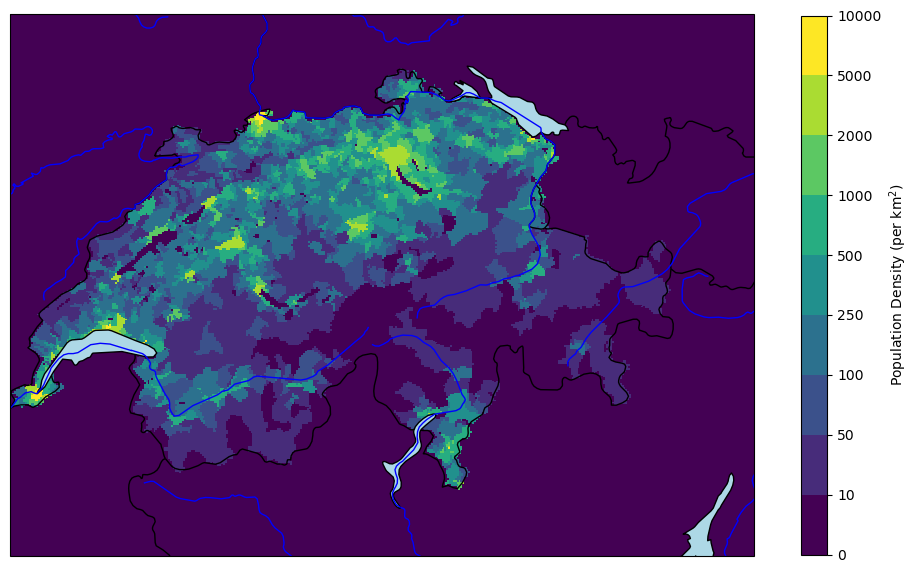

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import get_cmap

# File path to the population density array
POPULATION_DENSITY_FILE = "/users/fackerma/newproject1/Population_Density_CH_on_Radar_Grid.npy"

# Load the population density array
try:
    population_density = np.load(POPULATION_DENSITY_FILE)
    print("Population density file successfully loaded!")
    print("Shape of the population density array:", population_density.shape)
except FileNotFoundError:
    print(f"Error: Population density file not found at {POPULATION_DENSITY_FILE}")
    population_density = None
except Exception as e:
    print(f"Error loading population density file: {e}")
    population_density = None

# Plot the population density
if population_density is not None:
    # Define coordinate reference system
    projection = ccrs.epsg(3035)  # Assuming EPSG:3035

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': projection})

    # Set background colors
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # Define colormap
    cmap = get_cmap('viridis')  # You can choose a different colormap

    # Define bounds and normalization
    bounds = [0, 10, 50, 100, 250, 500, 1000, 2000, 5000, 10000]
    norm = BoundaryNorm(bounds, cmap.N)

    # Add map features
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.add_feature(cfeature.BORDERS, edgecolor='black')
    ax.add_feature(cfeature.LAKES, facecolor='lightblue', edgecolor='black')
    ax.add_feature(cfeature.RIVERS, edgecolor='blue')


    # Assuming clons and clats range from 6, 11, 45.5, 48
    extent = [6, 11, 45.5, 48]
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    img = ax.pcolormesh(clons, clats, population_density, cmap=cmap, norm=norm, transform=projection)

    # Add colorbar
    cbar = fig.colorbar(img, ax=ax, orientation='vertical', shrink=0.7)
    cbar.set_label('Population Density (per km$^2$)')


    # Save the plot
    plt.show()

else:
    print("No population density data to visualize.")


In [47]:
import numpy as np
from shapely.geometry import Polygon
import geopandas as gpd
from pyproj import Transformer

# File path to the population density array
POPULATION_DENSITY_FILE = "/users/fackerma/newproject1/Population_Density_CH_on_Radar_Grid.npy"

# Load the population density array
try:
    population_density = np.load(POPULATION_DENSITY_FILE)
    print("Population density file successfully loaded!")
    print("Shape of the population density array:", population_density.shape)
except FileNotFoundError:
    print(f"Error: Population density file not found at {POPULATION_DENSITY_FILE}")
    population_density = None
except Exception as e:
    print(f"Error loading population density file: {e}")
    population_density = None

# Create mask for high-density areas
mask = population_density > 1000
rows, cols = np.where(mask)

# Vectorized coordinate calculation for all cells meeting criteria
x_centers = X[rows, cols]  # Swiss grid X coordinates (EPSG:21781)
y_centers = Y[rows, cols]  # Swiss grid Y coordinates (EPSG:21781)

# Generate all polygon corners (5 points per cell: 4 corners + repeat first)
corner_offsets = np.array([[-500, +500], [+500, +500], [+500, -500], [-500, -500], [-500, +500]])
x_corners = x_centers[:, None] + corner_offsets[:, 0]
y_corners = y_centers[:, None] + corner_offsets[:, 1]

# Transform all corners to EPSG:3035
transformer = Transformer.from_crs(21781, 3035, always_xy=True)
flat_x = x_corners.ravel()
flat_y = y_corners.ravel()
tx, ty = transformer.transform(flat_x, flat_y)

# Reshape into individual polygons and create GeoDataFrame
polygons = [
    Polygon(np.column_stack([tx[i*5:(i+1)*5], ty[i*5:(i+1)*5]]))
    for i in range(len(rows))
]

gdf_popdense = gpd.GeoDataFrame(geometry=polygons, crs="EPSG:3035")

# Convert GeoDataFrame to WGS84 (EPSG:4326)
gdf_wgs84 = gdf_popdense.to_crs(epsg=4326)



Population density file successfully loaded!
Shape of the population density array: (640, 710)


In [52]:
from shapely.ops import unary_union

# Step 1: Merge adjacent/overlapping polygons using spatial union
merged_polygons = gdf_wgs84.unary_union

# Step 2: Create valid MultiPolygon geometry
if merged_polygons.geom_type == 'MultiPolygon':
    grouped_gdf = gpd.GeoDataFrame(geometry=list(merged_polygons.geoms), crs=gdf_wgs84.crs)
elif merged_polygons.is_empty:
    raise ValueError("No polygons found after union operation")
else:  # Single polygon case
    grouped_gdf = gpd.GeoDataFrame(geometry=[merged_polygons], crs=gdf_wgs84.crs)

# Optional: Simplify geometries to reduce complexity
grouped_gdf['geometry'] = grouped_gdf.simplify(tolerance=0.0001)  # ~10m at equator

# Validate geometries
grouped_gdf = grouped_gdf[grouped_gdf.is_valid]



# Read the Alps polygon shapefile
alps_gdf = gpd.read_file('alps_domain_def.shp')

# Assuming the Alps polygon is the 7th shape (adjust if needed)
alps_polygon = alps_gdf['geometry'].iloc[1:2]


# Remove polygons in grouped_gdf that intersect with the Alps polygon
grouped_gdf = grouped_gdf[~grouped_gdf['geometry'].intersects(alps_polygon)]


/tmp/ipykernel_115848/1243952352.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  merged_polygons = gdf_wgs84.unary_union
/tmp/ipykernel_115848/1243952352.py:30: UserWarning: The indices of the left and right GeoSeries' are not equal, and therefore they will be aligned (reordering and/or introducing missing values) before executing the operation. If this alignment is the desired behaviour, you can silence this warning by passing 'align=True'. If you don't want alignment and protect yourself of accidentally aligning, you can pass 'align=False'.
  grouped_gdf = grouped_gdf[~grouped_gdf['geometry'].intersects(alps_polygon)]


In [ ]:
from shapely.ops import unary_union

# Step 1: Merge adjacent/overlapping polygons using spatial union
merged_polygons = gdf_wgs84.unary_union

# Step 2: Create valid MultiPolygon geometry
if merged_polygons.geom_type == 'MultiPolygon':
    grouped_gdf = gpd.GeoDataFrame(geometry=list(merged_polygons.geoms), crs=gdf_wgs84.crs)
elif merged_polygons.is_empty:
    raise ValueError("No polygons found after union operation")
else:  # Single polygon case
    grouped_gdf = gpd.GeoDataFrame(geometry=[merged_polygons], crs=gdf_wgs84.crs)

# Optional: Simplify geometries to reduce complexity
grouped_gdf['geometry'] = grouped_gdf['geometry'].simplify(tolerance=0.0001)  # ~10m at equator

# Validate geometries
grouped_gdf = grouped_gdf[grouped_gdf['geometry'].is_valid]

# Read the Alps polygon shapefile
alps_gdf = gpd.read_file('alps_domain_def.shp')

# Assuming the Alps polygon is the first shape (adjust if needed)
alps_polygon = alps_gdf['geometry'].iloc[0]

# Remove polygons in grouped_gdf that intersect with the Alps polygon
grouped_gdf = grouped_gdf[~grouped_gdf['geometry'].intersects(alps_polygon)]


In [ ]:
#grouped_gdf.to_file("polygons_wgs84_1000.gpkg", driver="GPKG")

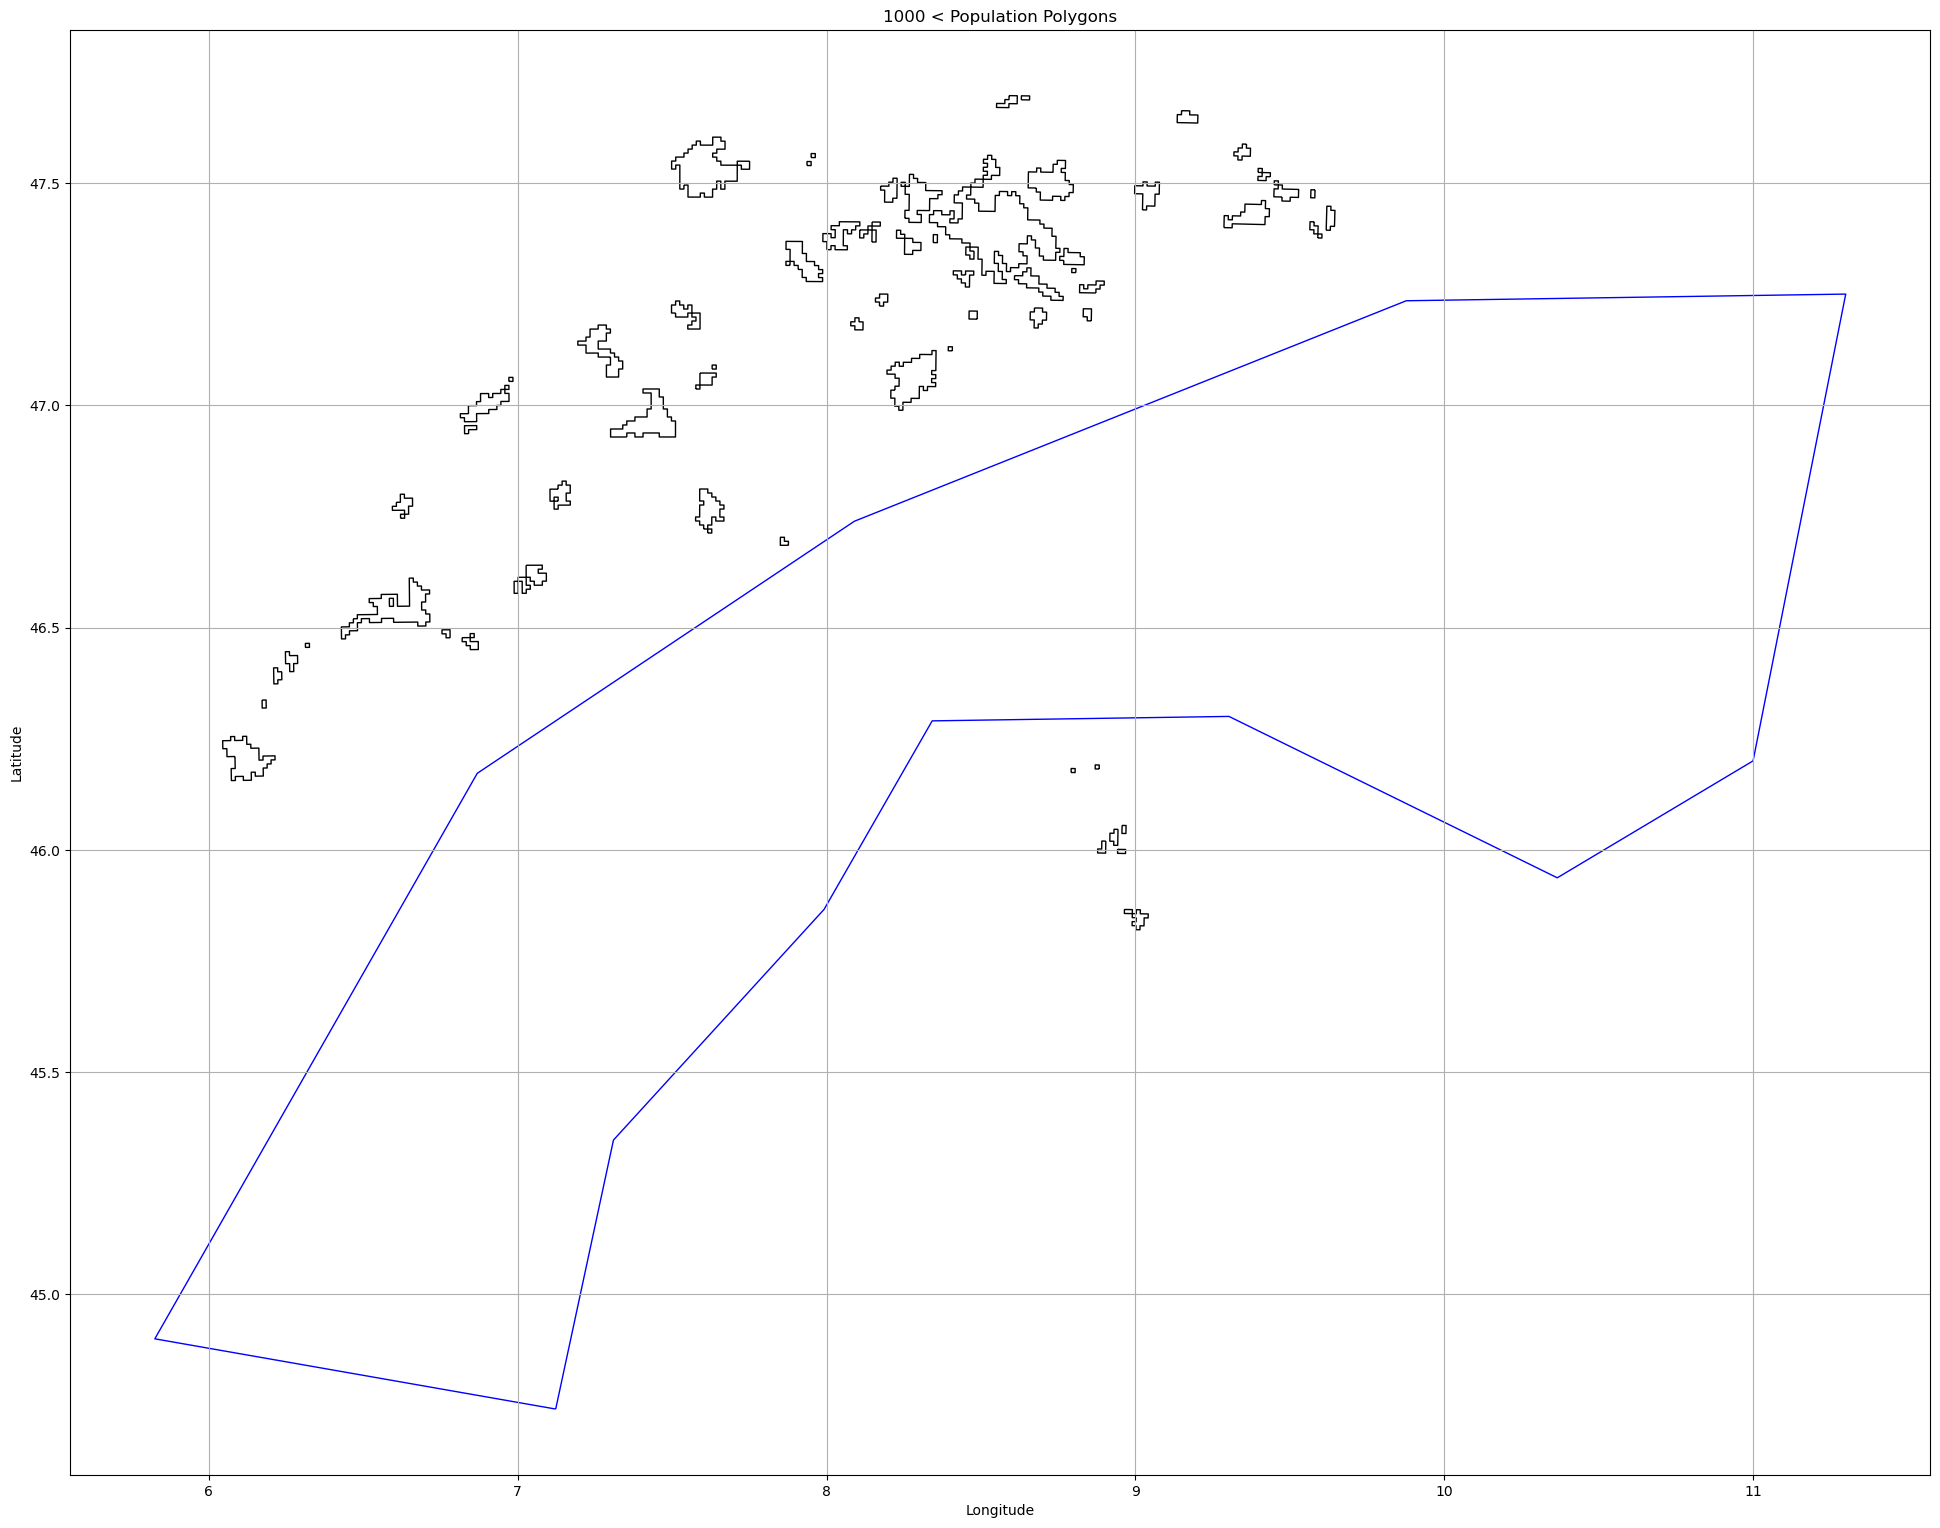

In [54]:
fig, ax = plt.subplots(figsize=(24, 20))
grouped_gdf.plot(ax=ax, edgecolor='black', facecolor='none')
alps_polygon.plot(ax=ax, edgecolor='blue', facecolor='none')
ax.set_title('1000 < Population Polygons')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.grid(True)
#plt.savefig("/users/fackerma/newproject1/figures/Ground_Truth/1000_pop_polygons.png")


## Check positive and negative Cases

In [1]:
import pandas as pd
import pickle
from pathlib import Path
from tqdm import tqdm

base_path = Path("/scratch/mch/fackerma/orders/TRT_processing_3/")
directories = [f"2023/"]  # Update with actual directory names

for directory in directories:
    dir_path = base_path / directory
    yes_count = 0
    no_count = 0
    
    # Get all .pkl files (consider using generator for large collections)
    pkl_files = list(dir_path.glob("*.pkl"))
    
    for file_path in tqdm(pkl_files, desc=f"Processing {directory}"):
        try:
            with open(file_path, 'rb') as f:
                df = pickle.load(f)
                
            # Count occurrences
            counts = df['Gust_Flag'].value_counts()
            yes_count += counts.get('Yes', 0)
            no_count += counts.get('No', 0)
            
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
    
    print(f"\nResults for {directory}:")
    print(f"Total 'Yes': {yes_count}")
    print(f"Total 'No': {no_count}\n")


Processing 2023/: 100%|██████████| 52992/52992 [14:04<00:00, 62.77it/s]


Results for 2023/:
Total 'Yes': 861
Total 'No': 2700



In [ ]:
import os
import pandas as pd
from pathlib import Path

# Initialize list to store valid times
valid_times = []

# Base directory path
base_path = Path("/scratch/mch/fackerma/orders/TRT_processing_3/")

# Process each year directory
for year in range(2019, 2024):
    year_dir = base_path / f"{year}"
    
    if not year_dir.exists():
        continue

    # Process each .pkl file
    for pkl_file in year_dir.glob("TRT_*.pkl"):
        filename = pkl_file.stem
        parts = filename.split("_")
        
        if len(parts) >= 3:
            try:
                date_str = parts[1]
                time_str = parts[2]
                formatted_time = f"{date_str} {time_str[:2]}:{time_str[2:]}"
                
                df = pd.read_pickle(pkl_file)
                if 'Gust_Marker' in df.columns:
                    if df['Gust_Flag'].isin(['Yes', 'No']).any():
                        valid_times.append(formatted_time)
            except Exception as e:
                print(f"Error processing {pkl_file}: {str(e)}")

# Create and format final dataframe
result_df = pd.DataFrame({'Valid_Time': valid_times})
result_df['Valid_Time'] = pd.to_datetime(result_df['Valid_Time'])
result_df = result_df.sort_values('Valid_Time').reset_index(drop=True)
result_df['Valid_Time'] = result_df['Valid_Time'].dt.strftime('%Y-%m-%d %H:%M')

# Save to specified location
output_path = base_path.parent / "Extraction_dates_3.pkl"
result_df.to_pickle(output_path)
print(f"\n✅ Successfully saved {len(result_df)} entries to:\n{output_path}")

# Optional: Verify load
test_load = pd.read_pickle(output_path)
print(f"\nVerification: Loaded {len(test_load)} records from saved file")



✅ Successfully saved 0 entries to:
/scratch/mch/fackerma/orders/Extraction_dates_3.pkl

Verification: Loaded 0 records from saved file


## Check a Ground Truth file

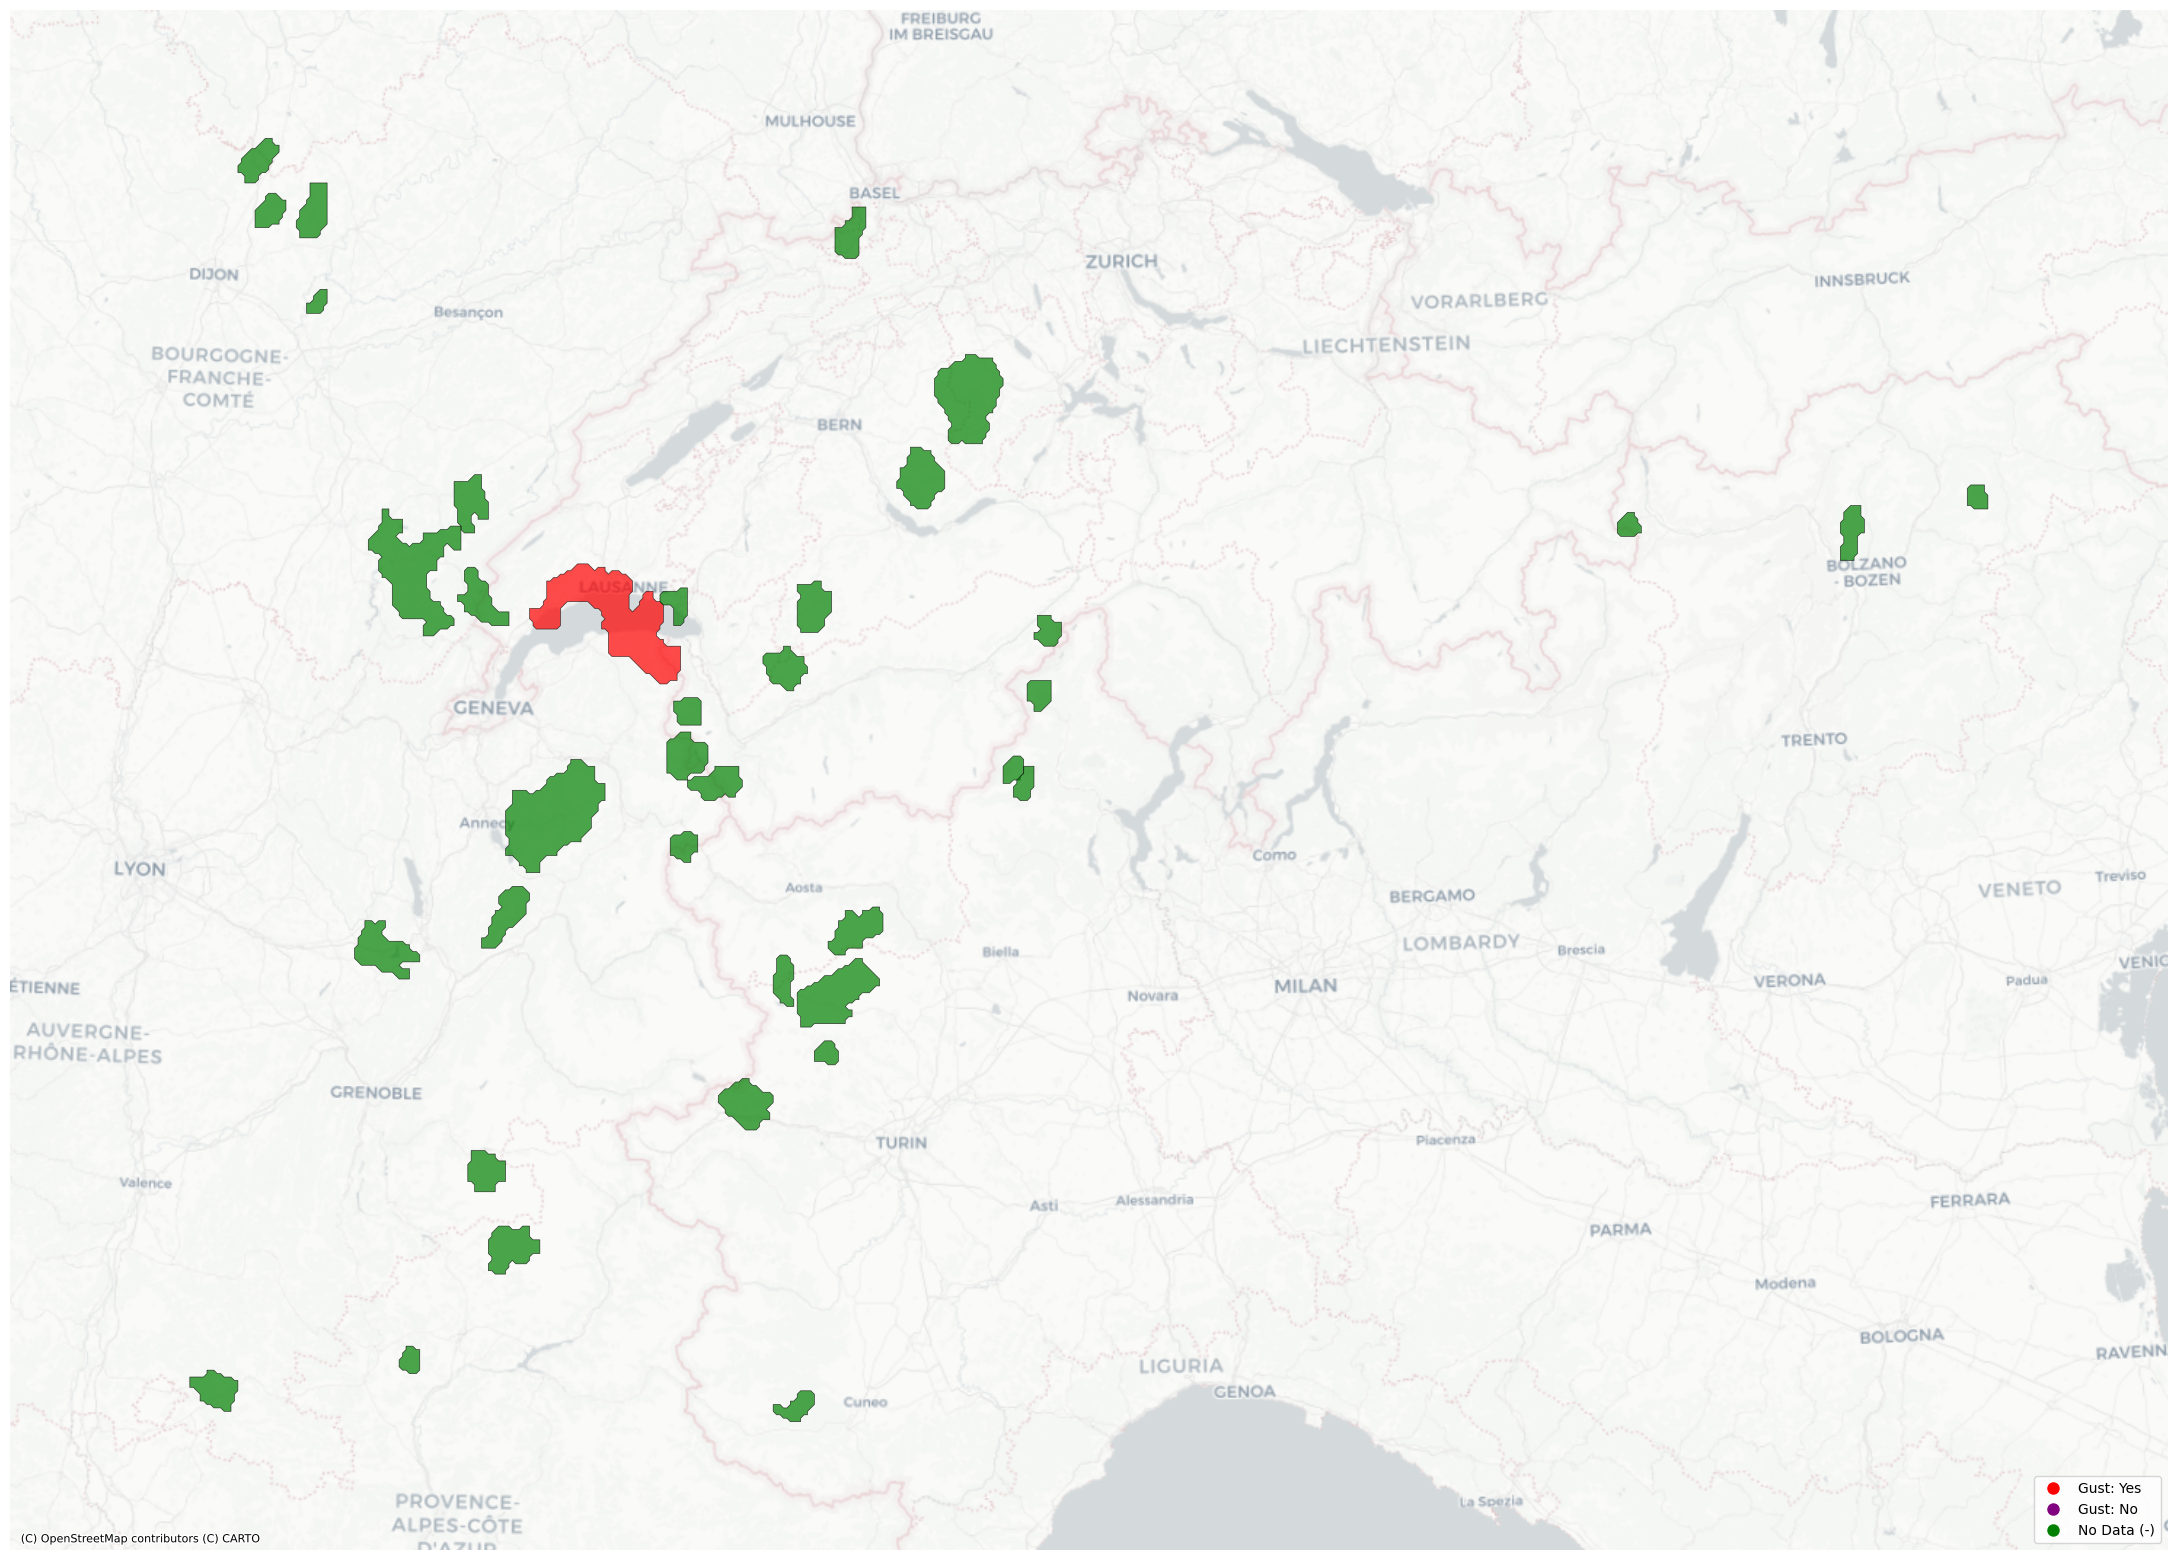

In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from pathlib import Path

# Load and prepare data
file_path = Path("/scratch/mch/fackerma/orders/TRT_processing_3/2019/TRT_2019-06-15_1525.pkl")
df = pd.read_pickle(file_path)
gdf = gpd.GeoDataFrame(df, geometry='geometry').set_crs("EPSG:4326")

# Convert to Swiss coordinate system (EPSG:2056) for accurate positioning
gdf = gdf.to_crs("EPSG:2056")

# Create color mapping
color_mapping = {
    'Yes': 'red',
    'No': 'purple',
    '-': 'green'
}
gdf['color'] = gdf['Gust_Flag'].map(color_mapping).fillna('green')

# Create plot with dynamic bounds
fig, ax = plt.subplots(figsize=(35, 20))

# Plot all polygons at once with color mapping
gdf.plot(ax=ax, color=gdf['color'], edgecolor='black', 
         linewidth=0.5, alpha=0.7, legend=True)

# Calculate dynamic bounds with 10% buffer
minx, miny, maxx, maxy = gdf.total_bounds
delta_x = (maxx - minx) * 0.1  # 10% buffer
delta_y = (maxy - miny) * 0.1

ax.set_xlim(minx - delta_x, maxx + delta_x)
ax.set_ylim(miny - delta_y, maxy + delta_y)

# Add contextily basemap with proper zoom
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron,
                zoom=8)  # Auto-zoom based on extent

# Add map elements
ax.set_axis_off()  # Cleaner look without axis labels

# Create custom legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Gust: Yes',
               markerfacecolor='red', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Gust: No',
               markerfacecolor='purple', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='No Data (-)',
               markerfacecolor='green', markersize=10)
]
ax.legend(handles=legend_elements, loc='lower right')

# Save output


## Process the Timestamps of the Ground Truth

In [3]:
import pandas as pd
from pathlib import Path

# Define the file path
file_path = Path("/scratch/mch/fackerma/orders/Extraction_dates_3.pkl")

# Load the pickle file into a DataFrame
try:
    df = pd.read_pickle(file_path)
    print("Successfully loaded the DataFrame:")
    print(df.head())  # Display the first few rows of the DataFrame
except FileNotFoundError:
    print(f"Error: The file '{file_path}' does not exist.")
except Exception as e:
    print(f"An error occurred while loading the file: {e}")


Successfully loaded the DataFrame:
         Valid_Time
0  2019-05-11 12:30
1  2019-05-11 12:35
2  2019-05-11 12:40
3  2019-05-11 12:50
4  2019-05-11 12:55


In [4]:

# Assuming df is your existing dataframe
df['Valid_Time'] = pd.to_datetime(df['Valid_Time']).dt.strftime('%Y%m%d%H%M%S')

# Display the updated dataframe
print(df.head())


       Valid_Time
0  20190511123000
1  20190511123500
2  20190511124000
3  20190511125000
4  20190511125500


In [5]:

def expand_timestamps(timestamp):
    dt = pd.to_datetime(timestamp, format='%Y%m%d%H%M%S')
    times = [dt - pd.Timedelta(minutes=15-i*5) for i in range(4)] + \
            [dt + pd.Timedelta(minutes=5+i*5) for i in range(3)]
    return [t.strftime('%Y%m%d%H%M%S') for t in times]

# Assuming df is your DataFrame
new_rows = df['Valid_Time'].apply(expand_timestamps).explode()
df_expanded = pd.DataFrame({'Valid_Time': new_rows})

# Sort and remove duplicates
df_expanded = df_expanded.sort_values('Valid_Time').drop_duplicates()

# Reset the index
df_expanded = df_expanded.reset_index(drop=True)

print(df_expanded.head(40))


        Valid_Time
0   20190511121500
1   20190511122000
2   20190511122500
3   20190511123000
4   20190511123500
5   20190511124000
6   20190511124500
7   20190511125000
8   20190511125500
9   20190511130000
10  20190511130500
11  20190511131000
12  20190511131500
13  20190511132000
14  20190511132500
15  20190511133000
16  20190511133500
17  20190511134000
18  20190511134500
19  20190615143000
20  20190615143500
21  20190615144000
22  20190615144500
23  20190615145000
24  20190615145500
25  20190615150000
26  20190615150500
27  20190615151000
28  20190615151500
29  20190615152000
30  20190615152500
31  20190615153000
32  20190615153500
33  20190615154000
34  20190615154500
35  20190615155000
36  20190615155500
37  20190615160500
38  20190615161000
39  20190615161500


In [6]:
# Check for duplicates
duplicates = df_expanded.duplicated()

# Print the result
print(duplicates)

# Count the number of duplicates
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows: {num_duplicates}")

# If you want to see the duplicate rows themselves
if num_duplicates > 0:
    duplicate_rows = df_expanded[duplicates]
    print("Duplicate rows:")
    print(duplicate_rows)


0        False
1        False
2        False
3        False
4        False
         ...  
14226    False
14227    False
14228    False
14229    False
14230    False
Length: 14231, dtype: bool
Number of duplicate rows: 0


In [7]:
# Save the date files 

#df_expanded.to_pickle("/scratch/mch/fackerma/orders/Extraction_dates_YYYYMMDDhhmmss.pkl")

df_expanded.to_csv("/scratch/mch/fackerma/orders/Reworked_gust_extraction_dates.txt", sep='\t', index=False)



## Handle Metainfo

In [4]:
import pandas as pd
from pathlib import Path

# Define the file path
file_path = Path("/scratch/mch/fackerma/orders/Extracted_metainfo.pkl")

# Load the pickle file into a DataFrame
try:
    df_gust = pd.read_pickle(file_path)
    print("Successfully loaded the DataFrame:")
    print(df_gust.head())  # Display the first few rows of the DataFrame
except FileNotFoundError:
    print(f"Error: The file '{file_path}' does not exist.")
except Exception as e:
    print(f"An error occurred while loading the file: {e}")

Successfully loaded the DataFrame:
                                            geometry           traj_ID  \
0  POLYGON ((6.1687 46.4897, 6.1559 46.4806, 6.14...  2022062519100029   
1  POLYGON ((8.4531 47.4548, 8.4397 47.446, 8.439...  2022050516000055   
2  POLYGON ((6.0054 46.2628, 6.0056 46.2538, 5.99...  2022070410050024   
3  POLYGON ((7.3664 46.9735, 7.3664 46.9196, 7.40...  2022050313050051   
4  POLYGON ((8.8371 47.4328, 8.8366 47.4149, 8.84...  2022062318150164   

   yyyymmddHHMM     lon      lat  ell_L ell_S ell_or area  vel_x  ...  \
0  202206251920  6.2212  46.4043  10.30  7.65  126.7  157  27.57  ...   
1  202205051640  8.5275  47.3747  12.91  4.40  115.6   88  -6.12  ...   
2  202207041100  6.0683  46.2261  10.39  3.69   83.2   76  24.03  ...   
3  202205031310  7.4212  46.9308   5.57  3.57  113.9   40  -1.43  ...   
4  202206231900  8.8993  47.3325  12.53  7.80   87.2  174   6.35  ...   

  nrPOHthr080 nrPOHthr090 nrPOHthr100                 chx                 chy  \


In [6]:
import folium
import pandas as pd
from collections import defaultdict

# Convert coordinates to numeric and clean data
df_gust['lat'] = pd.to_numeric(df_gust['lat'], errors='coerce')
df_gust['lon'] = pd.to_numeric(df_gust['lon'], errors='coerce')
df_gust = df_gust.dropna(subset=['lat', 'lon'])

# Create a map centered on Switzerland
switzerland_map = folium.Map(location=[46.8182, 8.2275], zoom_start=8)

# Dictionary to store trajectory points
trajectories = defaultdict(list)

# Function to determine color
def get_color(row):
    markers = [
        row.get('STA Marker', 0),
        row.get('ESWD Marker', 0),
        row.get('CS Marker', 0)
    ]
    non_zero = sum(1 for m in markers if m != 0)
    
    if non_zero >= 2:
        return 'black'
    elif markers[2] != 0:  # CS Marker
        return 'red'
    elif markers[1] != 0:  # ESWD Marker
        return 'yellow'
    elif markers[0] != 0:  # STA Marker
        return 'blue'
    else:
        return 'green'

# Add markers and collect trajectory points
for idx, row in df_gust.iterrows():
    try:
        lat = float(row['lat'])
        lon = float(row['lon'])
    except (ValueError, TypeError):
        continue  # Skip invalid coordinates
    
    # Add gust flag filter here
    if row['Gust_Flag'] != 'Yes':
        continue
    
    color = get_color(row)
    
    folium.CircleMarker(
        location=[lat, lon],
        radius=3,
        popup=f"Lat: {lat:.4f}, Lon: {lon:.4f}<br>traj_ID: {row['traj_ID']}",
        color=color,
        fill=True,
        fill_color=color
    ).add_to(switzerland_map)
    
    trajectories[row['traj_ID']].append((lat, lon))

switzerland_map
